<a href="https://colab.research.google.com/github/TWS615/Bank-Churn-Prediction/blob/main/LoanRiskClassification_TanWeiSiong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Risk Classification




## Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
%matplotlib inline

from scipy.stats import norm
import sklearn.metrics as metrics
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, RobustScaler, PowerTransformer, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
from scipy.stats import yeojohnson, boxcox
import time

## Model
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Introduction
  

In the financial sector, good loan portfolio management is critical to financial institutions' success. One of the crucial aspects of this management is the loan quality classification, which evaluates the risk of individual loans.

The aim of this project is to build a predictive model that can classify whether the loan quality is good or bad, which is also known as binary classification. A loan quality classification project plays a vital role in enabling financial institutions to make informed and data-driven decisions in their lending practices.

The dataset of this project consists of the information of the people's loan and payment data, the data will be used to train for multiples model to predict loan risk or quality (loan repayment).

## Load Data

#### Loan Data

In [ ]:
# Load the data
df_loan = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataSet/loan.csv", parse_dates=['applicationDate', 'originatedDate'])
print(f"Dataset size (row, col): {df_loan.shape}")
# Check both the datatypes and if there is missing values
print(f"{df_loan.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{df_loan.isnull().sum()}")
df_loan.head(5)

Dataset size (row, col): (577682, 19)
loanId                                      object
anon_ssn                                    object
payFrequency                                object
apr                                        float64
applicationDate                     datetime64[ns]
originated                                    bool
originatedDate                      datetime64[ns]
nPaidOff                                   float64
approved                                      bool
isFunded                                     int64
loanStatus                                  object
loanAmount                                 float64
originallyScheduledPaymentAmount           float64
state                                       object
leadType                                    object
leadCost                                     int64
fpStatus                                    object
clarityFraudId                              object
hasCF                                       

loanId                          anon_ssn payFrequency    apr  \
0  LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0   
1  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2  LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845            B  590.0   
3  LL-I-02272596  9be6f443bb97db7e95fa0c281d34da91            B  360.0   
4  LL-I-09542882  63b5494f60b5c19c827c7b068443752c            B  590.0   

          applicationDate  originated          originatedDate  nPaidOff  \
0 2016-02-23 17:29:01.940       False                     NaT       0.0   
1 2016-01-19 22:07:36.778        True 2016-01-20 15:49:18.846       0.0   
2 2016-08-01 13:51:14.709       False                     NaT       0.0   
3 2015-08-06 23:58:08.880       False                     NaT       0.0   
4 2016-06-05 22:31:34.304       False                     NaT       0.0   

   approved  isFunded             loanStatus  loanAmount  \
0     False         0  Withdrawn Application       500.0   
1      True         1          Paid Off Loan      3000.0   
2     False         0  Withdrawn Application       400.0   
3     False         0  Withdrawn Application       500.0   
4     False         0               Rejected       350.0   

   originallyScheduledPaymentAmount state     leadType  leadCost fpStatus  \
0                            978.27    IL  bvMandatory         6      NaN   
1                           6395.19    CA    prescreen         0  Checked   
2                           1199.45    MO  bvMandatory         3      NaN   
3                           1074.05    IL  bvMandatory         3      NaN   
4                            814.37    NV  bvMandatory         3      NaN   

             clarityFraudId  hasCF  
0  5669ef78e4b0c9d3936440e6      1  
1  569eb3a3e4b096699f685d64      1  
2  579eab11e4b0d0502870ef2f      1  
3  555b1e95e4b0f6f11b267c18      1  
4  5754a91be4b0c6a2bf424772      1

In [ ]:
df_loan.describe()

apr       nPaidOff       isFunded     loanAmount  \
count  573760.000000  577658.000000  577682.000000  575432.000000   
mean      553.080972       0.037887       0.067480     514.245084   
std       110.046159       0.333366       0.250852     320.939929   
min         0.000000       0.000000       0.000000       0.000000   
25%       490.000000       0.000000       0.000000     350.000000   
50%       590.000000       0.000000       0.000000     500.000000   
75%       601.000000       0.000000       0.000000     500.000000   
max       705.590000      21.000000       1.000000    5000.000000   

       originallyScheduledPaymentAmount       leadCost          hasCF  
count                     577682.000000  577682.000000  577682.000000  
mean                        1428.897209       7.854389       0.619187  
std                          925.009141      12.853451       0.485587  
min                         -816.710000       0.000000       0.000000  
25%                         1023.640000       3.000000       0.000000  
50%                         1245.250000       3.000000       1.000000  
75%                         1615.660000       6.000000       1.000000  
max                        19963.630000     200.000000       1.000000

####  Payment Data

In [ ]:
# Load the data
df_payment = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataSet/payment.csv")
print(f"Dataset size (row, col): {df_payment.shape}")
# Check both the datatypes and if there is missing values
print(f"{df_payment.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{df_payment.isnull().sum()}")
df_payment.head(5)

Dataset size (row, col): (689364, 9)
loanId                object
installmentIndex       int64
isCollection            bool
paymentDate           object
principal            float64
fees                 float64
paymentAmount        float64
paymentStatus         object
paymentReturnCode     object
dtype: object

Sum of null values in each feature:
-----------------------------------
loanId                    0
installmentIndex          0
isCollection              0
paymentDate               0
principal                 0
fees                      0
paymentAmount             0
paymentStatus             0
paymentReturnCode    657831
dtype: int64


loanId  installmentIndex  isCollection          paymentDate  \
0  LL-I-00000021                 1         False  2014-12-19T05:00:00   
1  LL-I-00000021                 2         False  2015-01-02T05:00:00   
2  LL-I-00000021                 3         False  2015-01-16T05:00:00   
3  LL-I-00000021                 4         False  2015-01-30T05:00:00   
4  LL-I-00000021                 5         False  2015-02-13T05:00:00   

   principal    fees  paymentAmount paymentStatus paymentReturnCode  
0      22.33  147.28         169.61       Checked               NaN  
1      26.44  143.17         169.61       Checked               NaN  
2      31.30  138.31         169.61       Checked               NaN  
3      37.07  132.54         169.61       Checked               NaN  
4      43.89  125.72         169.61       Checked               NaN

In [ ]:
df_payment.describe()

installmentIndex      principal           fees  paymentAmount
count     689364.000000  689364.000000  689364.000000  689364.000000
mean          10.553222      45.557543      67.003994     112.680232
std            8.049530      81.724683      59.789510     105.783710
min            1.000000    -303.370000     -42.560000    -337.700000
25%            5.000000      13.180000      28.820000      56.810000
50%            9.000000      27.610000      51.300000      86.340000
75%           14.000000      53.380000      86.440000     135.090000
max          105.000000    4000.000000    1257.710000    4063.600000

### Clarity Underwritting variables

In [ ]:
# Load the data
df_cuv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataSet/clarity_underwriting_variables.csv")
# rename column
df_cuv.columns = [col.replace('.underwritingdataclarity.clearfraud.', '') for col in df_cuv.columns]
print(f"Dataset size (row, col): {df_cuv.shape}")
# Check both the datatypes and if there is missing values
print(f"{df_cuv.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{df_cuv.isnull().sum()}")
df_cuv.head(5)


<ipython-input-7-f5d5c17a83d8>:2: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cuv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataSet/clarity_underwriting_variables.csv")


Dataset size (row, col): (49752, 54)
clearfraudinquiry.thirtydaysago                                    float64
clearfraudinquiry.twentyfourhoursago                               float64
clearfraudinquiry.oneminuteago                                     float64
clearfraudinquiry.onehourago                                       float64
clearfraudinquiry.ninetydaysago                                    float64
clearfraudinquiry.sevendaysago                                     float64
clearfraudinquiry.tenminutesago                                    float64
clearfraudinquiry.fifteendaysago                                   float64
clearfraudinquiry.threesixtyfivedaysago                            float64
clearfraudindicator.inquiryonfilecurrentaddressconflict             object
clearfraudindicator.totalnumberoffraudindicators                   float64
clearfraudindicator.telephonenumberinconsistentwithaddress          object
clearfraudindicator.inquiryageyoungerthanssnissuedate          

clearfraudinquiry.thirtydaysago  clearfraudinquiry.twentyfourhoursago  \
0                              8.0                                   2.0   
1                              5.0                                   2.0   
2                              9.0                                   4.0   
3                              3.0                                   2.0   
4                              5.0                                   5.0   

   clearfraudinquiry.oneminuteago  clearfraudinquiry.onehourago  \
0                             2.0                           2.0   
1                             2.0                           2.0   
2                             2.0                           3.0   
3                             2.0                           2.0   
4                             2.0                           2.0   

   clearfraudinquiry.ninetydaysago  clearfraudinquiry.sevendaysago  \
0                              8.0                             2.0   
1                             11.0                             2.0   
2                             10.0                             8.0   
3                              9.0                             2.0   
4                              6.0                             5.0   

   clearfraudinquiry.tenminutesago  clearfraudinquiry.fifteendaysago  \
0                              2.0                               5.0   
1                              2.0                               4.0   
2                              2.0                               9.0   
3                              2.0                               2.0   
4                              2.0                               5.0   

   clearfraudinquiry.threesixtyfivedaysago  \
0                                     10.0   
1                                     21.0   
2                                     25.0   
3                                      9.0   
4                                      6.0   

  clearfraudindicator.inquiryonfilecurrentaddressconflict  \
0                                              False        
1                                               True        
2                                              False        
3                                              False        
4                                              False        

   clearfraudindicator.totalnumberoffraudindicators  \
0                                               2.0   
1                                               3.0   
2                                               3.0   
3                                               1.0   
4                                               1.0   

  clearfraudindicator.telephonenumberinconsistentwithaddress  \
0                                               True           
1                                               True           
2                                               True           
3                                               True           
4                                               True           

  clearfraudindicator.inquiryageyoungerthanssnissuedate  \
0                                              False      
1                                              False      
2                                              False      
3                                              False      
4                                              False      

  clearfraudindicator.onfileaddresscautious  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

  clearfraudindicator.inquiryaddressnonresidential  \
0                                             True   
1                                            False   
2                                            False   
3                                            False   
4                    

In [ ]:
df_cuv.describe()

clearfraudinquiry.thirtydaysago  clearfraudinquiry.twentyfourhoursago  \
count                     49750.000000                          49750.000000   
mean                          7.313628                              4.601990   
std                           6.327122                              3.302288   
min                           0.000000                              0.000000   
25%                           3.000000                              3.000000   
50%                           5.000000                              3.000000   
75%                           9.000000                              5.000000   
max                          89.000000                             60.000000   

       clearfraudinquiry.oneminuteago  clearfraudinquiry.onehourago  \
count                    49750.000000                  49750.000000   
mean                         2.343980                      4.006874   
std                          1.436345                      2.697831   
min                          0.000000                      0.000000   
25%                          1.000000                      3.000000   
50%                          3.000000                      3.000000   
75%                          3.000000                      5.000000   
max                         16.000000                     42.000000   

       clearfraudinquiry.ninetydaysago  clearfraudinquiry.sevendaysago  \
count                     49750.000000                    49750.000000   
mean                         10.554513                        5.423799   
std                          10.450845                        4.110483   
min                           0.000000                        0.000000   
25%                           4.000000                        3.000000   
50%                           7.000000                        4.000000   
75%                          13.000000                        6.000000   
max                         202.000000                       64.000000   

       clearfraudinquiry.tenminutesago  clearfraudinquiry.fifteendaysago  \
count                     49750.000000                      49750.000000   
mean                          3.292121                          6.155578   
std                           2.109667                          4.952620   
min                           0.000000                          0.000000   
25%                           2.000000                          3.000000   
50%                           3.000000                          5.000000   
75%                           4.000000                          7.000000   
max                          35.000000                         83.000000   

       clearfraudinquiry.threesixtyfivedaysago  \
count                             49750.000000   
mean                                 20.302291   
std                                  23.771239   
min                                   0.000000   
25%                                   6.000000   
50%                                  12.000000   
75%                                  25.000000   
max                                 438.000000   

       clearfraudindicator.totalnumberoffraudindicators  \
count                                      49735.000000   
mean                                           2.118327   
std                                            1.254602   
min                                            0.000000   
25%                                            1.000000   
50%                                            2.000000   
75%                                            3.000000   
max                                            8.000000   

       clearfraudindicator.maxnumberofssnswithanybankaccount  \
count                                       49735.000000       
mean                                            7.202554       
std                                            79.908530       
min                                             1.00000

## Join DataFrame

Missing value will be handle here before going to EDA

In [ ]:
merged_df = pd.merge(df_loan, df_cuv, how='left', left_on='clarityFraudId', right_on='underwritingid')
#get only funded loan since they are ultimately	funded
merged_df = merged_df[merged_df['isFunded'] == 1]
print(f"Dataset size (row, col): {merged_df.shape}")
# Check both the datatypes and if there is missing values
print(f"{merged_df.dtypes}\n")
merged_df.head(5)

Dataset size (row, col): (38982, 73)
loanId                                                                     object
anon_ssn                                                                   object
payFrequency                                                               object
apr                                                                       float64
applicationDate                                                    datetime64[ns]
originated                                                                   bool
originatedDate                                                     datetime64[ns]
nPaidOff                                                                  float64
approved                                                                     bool
isFunded                                                                    int64
loanStatus                                                                 object
loanAmount                                                   

loanId                          anon_ssn payFrequency    apr  \
1   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
15  LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0   
33  LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0   
47  LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0   
54  LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   

           applicationDate  originated          originatedDate  nPaidOff  \
1  2016-01-19 22:07:36.778        True 2016-01-20 15:49:18.846       0.0   
15 2016-11-28 19:54:22.982        True 2016-11-29 20:30:40.640       2.0   
33 2017-03-01 15:55:41.823        True 2017-03-01 16:15:13.016       0.0   
47 2017-01-31 17:48:17.381        True 2017-01-31 18:00:14.520       2.0   
54 2016-08-27 09:08:05.442        True 2016-08-29 15:05:04.014       0.0   

    approved  isFunded     loanStatus  loanAmount  \
1       True         1  Paid Off Loan      3000.0   
15      True         1       New Loan       350.0   
33      True         1       New Loan       400.0   
47      True         1  Paid Off Loan      1250.0   
54      True         1  Paid Off Loan       800.0   

    originallyScheduledPaymentAmount state     leadType  leadCost fpStatus  \
1                            6395.19    CA    prescreen         0  Checked   
15                            893.88    MO      organic         0  Checked   
33                           1364.87    NJ         lead        40  Checked   
47                           3313.78    MO      organic         0  Checked   
54                           2432.08    CA  bvMandatory        10  Checked   

              clarityFraudId  hasCF  clearfraudinquiry.thirtydaysago  \
1   569eb3a3e4b096699f685d64      1                              3.0   
15                       NaN      0                              NaN   
33  58b6eef8e4b0b6fca82fd426      1                              3.0   
47  58450a15e4b0bb9d6d7344c7      1                              4.0   
54  578f9346e4b0810ad5e7b72e      1                             13.0   

    clearfraudinquiry.twentyfourhoursago  clearfraudinquiry.oneminuteago  \
1                                    3.0                             3.0   
15                                   NaN                             NaN   
33                                   3.0                             3.0   
47                                   4.0                             1.0   
54                                   3.0                             3.0   

    clearfraudinquiry.onehourago  clearfraudinquiry.ninetydaysago  \
1                            3.0                              3.0   
15                           NaN                              NaN   
33                           3.0                              3.0   
47                           4.0                              5.0   
54                           3.0                             42.0   

    clearfraudinquiry.sevendaysago  clearfraudinquiry.tenminutesago  \
1                              3.0                              3.0   
15                             NaN                              NaN   
33                             3.0                              3.0   
47                             4.0                              1.0   
54                             3.0                              3.0   

    clearfraudinquiry.fifteendaysago  clearfraudinquiry.threesixtyfivedaysago  \
1                                3.0                                      4.0   
15                               NaN                                      NaN   
33                               3.0                                      3.0   
47                               4.0                                     10.0   
54                               6.0                                    255.0   

   clearfraudindicator.inquiryonfilecurrentaddressconflict  \
1                                 

 The payment.csv is not being use to join
 in this project because the main purpose of this project is to predict whether approve the loan or not for the applicants. Thus, using the payment data may lead to overfitting / target leakage to the model. Besides, there is no payment data for the first time applicant.

In [ ]:
# Read through the column description and select only useful column
merged_df = merged_df[['loanId','anon_ssn','payFrequency', 'apr', 'applicationDate', 'originatedDate',
                       'nPaidOff','loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount',
                       'state', 'leadType', 'leadCost','fpStatus', 'clearfraudscore'
                      ]]
temp_merged_df = merged_df.copy()
temp_merged_df["durationToOriginate"] = ((merged_df['originatedDate'] - merged_df['applicationDate']).dt.total_seconds() / 3600).astype(float)
temp_merged_df.head(5)

loanId                          anon_ssn payFrequency    apr  \
1   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
15  LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0   
33  LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0   
47  LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0   
54  LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   

           applicationDate          originatedDate  nPaidOff     loanStatus  \
1  2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0  Paid Off Loan   
15 2016-11-28 19:54:22.982 2016-11-29 20:30:40.640       2.0       New Loan   
33 2017-03-01 15:55:41.823 2017-03-01 16:15:13.016       0.0       New Loan   
47 2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0  Paid Off Loan   
54 2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0  Paid Off Loan   

    loanAmount  originallyScheduledPaymentAmount state     leadType  leadCost  \
1       3000.0                           6395.19    CA    prescreen         0   
15       350.0                            893.88    MO      organic         0   
33       400.0                           1364.87    NJ         lead        40   
47      1250.0                           3313.78    MO      organic         0   
54       800.0                           2432.08    CA  bvMandatory        10   

   fpStatus  clearfraudscore  durationToOriginate  
1   Checked            879.0            17.695019  
15  Checked              NaN            24.604905  
33  Checked            658.0             0.325331  
47  Checked            835.0             0.199205  
54  Checked            624.0            53.949603

The duration between the application date and originated date can be an additional feature in this case, thus duration to originated will be calculated in hour and save as new column in the dataframe.

In [ ]:
print(f"Dataset size (row, col): {temp_merged_df.shape}")
temp_merged_df.describe()

Dataset size (row, col): (38982, 16)


apr      nPaidOff    loanAmount  \
count  38982.000000  38961.000000  38982.000000   
mean     527.410074      0.372218    639.727644   
std      124.604931      1.020026    478.619761   
min        0.000000      0.000000    100.000000   
25%      449.990000      0.000000    375.000000   
50%      590.000000      0.000000    500.000000   
75%      601.000000      0.000000    700.000000   
max      705.590000     21.000000   4687.000000   

       originallyScheduledPaymentAmount      leadCost  clearfraudscore  \
count                      38982.000000  38982.000000     32088.000000   
mean                        1753.363425     11.921169       685.383321   
std                         1282.300386     20.203014       127.256984   
min                          187.620000      0.000000       122.000000   
25%                         1035.560000      0.000000       594.000000   
50%                         1379.000000      3.000000       693.000000   
75%                         1995.877500     10.000000       784.000000   
max                        16868.150000    200.000000       965.000000   

       durationToOriginate  
count         38982.000000  
mean             24.856659  
std              79.798356  
min              -6.861352  
25%               0.429419  
50%               3.192684  
75%              20.885134  
max            5888.781163

We notice that the Min value for duration to originate is negative which quite abnormal since originatedDate should greater then application date.

In [ ]:
rows_with_issue = temp_merged_df[temp_merged_df['originatedDate'] < temp_merged_df['applicationDate']]
print("Count of rows with issue:",len(rows_with_issue))

merged_df = merged_df[merged_df['originatedDate'] >= merged_df['applicationDate']]
merged_df["durationToOriginate"] = ((merged_df['originatedDate'] - merged_df['applicationDate']).dt.total_seconds() / 3600).astype(float)
print(f"Dataset size (row, col): {merged_df.shape}")
merged_df.describe()

Count of rows with issue: 1
Dataset size (row, col): (38981, 16)


apr      nPaidOff    loanAmount  \
count  38981.000000  38961.000000  38981.000000   
mean     527.411324      0.372218    639.723532   
std      124.606285      1.020026    478.625212   
min        0.000000      0.000000    100.000000   
25%      449.990000      0.000000    375.000000   
50%      590.000000      0.000000    500.000000   
75%      601.000000      0.000000    700.000000   
max      705.590000     21.000000   4687.000000   

       originallyScheduledPaymentAmount      leadCost  clearfraudscore  \
count                      38981.000000  38981.000000     32088.000000   
mean                        1753.359168     11.921321       685.383321   
std                         1282.316558     20.203251       127.256984   
min                          187.620000      0.000000       122.000000   
25%                         1035.560000      0.000000       594.000000   
50%                         1379.000000      3.000000       693.000000   
75%                         1995.910000     10.000000       784.000000   
max                        16868.150000    200.000000       965.000000   

       durationToOriginate  
count         38981.000000  
mean             24.857472  
std              79.799218  
min               0.000096  
25%               0.429426  
50%               3.193001  
75%              20.886093  
max            5888.781163

After printed the total abnormal row, we can see that there is only one abnormal row thus we just drop then particular column.

 Since the aim of this project to analysis on funded loan, The column like isFunded and approved may be redundent so those column not being selected.

 The clearfraudscore in clarity_underwriting_variables.csv will be enough to do the analysis since other column are only useful in fraud detection. Therefore only this column being selected from this csv.

### Check Missing Value and Imputation

In [ ]:
## print column with missing value
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"By count:")
print(f"{merged_df.isnull().sum()}")
print(f"\nBy Percentage(%):")
print(f"{(merged_df.isnull().mean() * 100).round(2)} ")

Sum of null values in each feature:
-----------------------------------
By count:
loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
applicationDate                        0
originatedDate                         0
nPaidOff                              20
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
fpStatus                               9
clearfraudscore                     6893
durationToOriginate                    0
dtype: int64

By Percentage(%):
loanId                               0.00
anon_ssn                             0.00
payFrequency                         0.00
apr                                  0.00
applicationDate                      0.00
originatedDate      

There are 3 columns having missing values, which nPaidOff, fpStatus and clearfraudscore. There are only 38982 rows for the dataset which not consider as big. Thus, not consider to drop the missing value rows. The nPaidOff and clearfraudscore are numerical data thus can be imputate by it mode/mean/median. The missing value in fpStatus is having its own description, therefore the Nan value will be replace as a String None to remain the status.

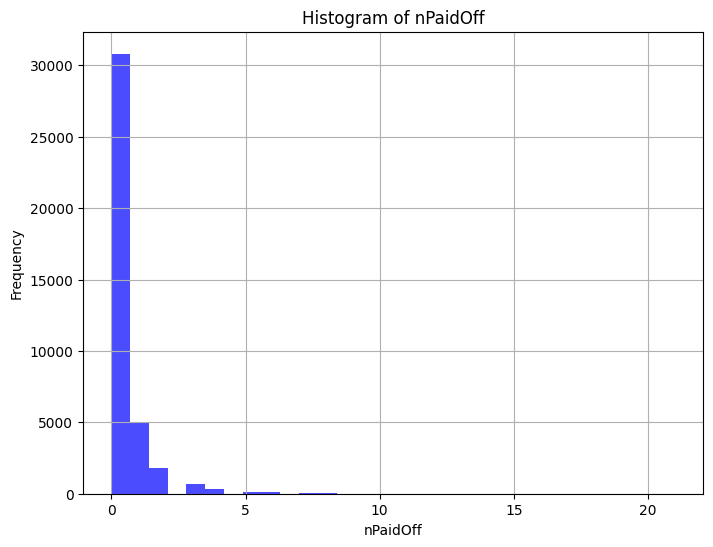

Skewness value for 'nPaidOff': 6.214662736747649


In [ ]:
def plot_histogram(df, column_name):
    if column_name not in df.columns:
      print(f"Column '{column_name}' not found in the DataFrame.")
      return
    plt.figure(figsize=(8, 6))
    plt.hist(df[column_name], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def print_skewness(df, column_name):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return
    skewness_value = df[column_name].skew()
    # skewness value > 0.75 consider not normal distribution
    print(f"Skewness value for '{column_name}': {skewness_value}")

plot_histogram(merged_df, 'nPaidOff')
print_skewness(merged_df, 'nPaidOff')

The histrogram above show there is strongly right skewed(positively skewed). We decide to use median to replace the missing value because median is not influenced by extreme values. Since data in this column are discrete integer values, the median will be rounded to nearest integer to aligns with the nature of data.

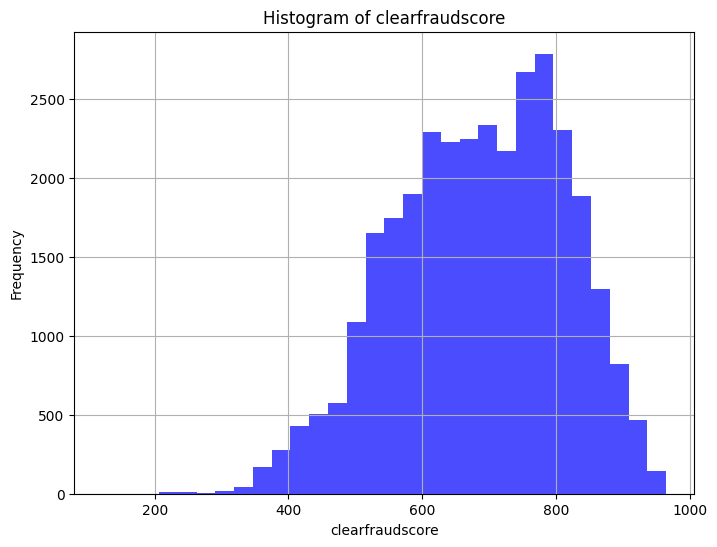

Skewness value for 'clearfraudscore': -0.30481464250241963


In [ ]:
plot_histogram(merged_df, 'clearfraudscore')
print_skewness(merged_df, 'clearfraudscore')

The skewness of the clearfraudscore is -0.304, which is a slightly negative skew, Since the skewness value is low, we can condlude that the clearfraudscore is normal distribution. Both median and mean can be use in this case. Median may be more robust option to impute missing value for this column bacause median estimate of the central tendency and it less influenced by the skewness.

In [ ]:
merged_df['nPaidOff'].fillna(round(merged_df['nPaidOff'].median()), inplace=True)
merged_df['clearfraudscore'].fillna(round(merged_df['clearfraudscore'].median()), inplace=True)
merged_df['clearfraudscore'].fillna("None", inplace=True)

## Exploratory Data Analysis(EDA)



#### Numerical Data analysis

In [ ]:
##Split column into categorical and numerical to analyse for each type
df_cols = merged_df.columns
numerical_cols = merged_df.select_dtypes(include=['int', 'float']).columns
categorical_cols = list(set(df_cols) - set(numerical_cols))


##### Correlation matrix

Correlation in data analysis measures the statistical relationship between two variables. It quantifies how changes in one variable relate to changes in another.

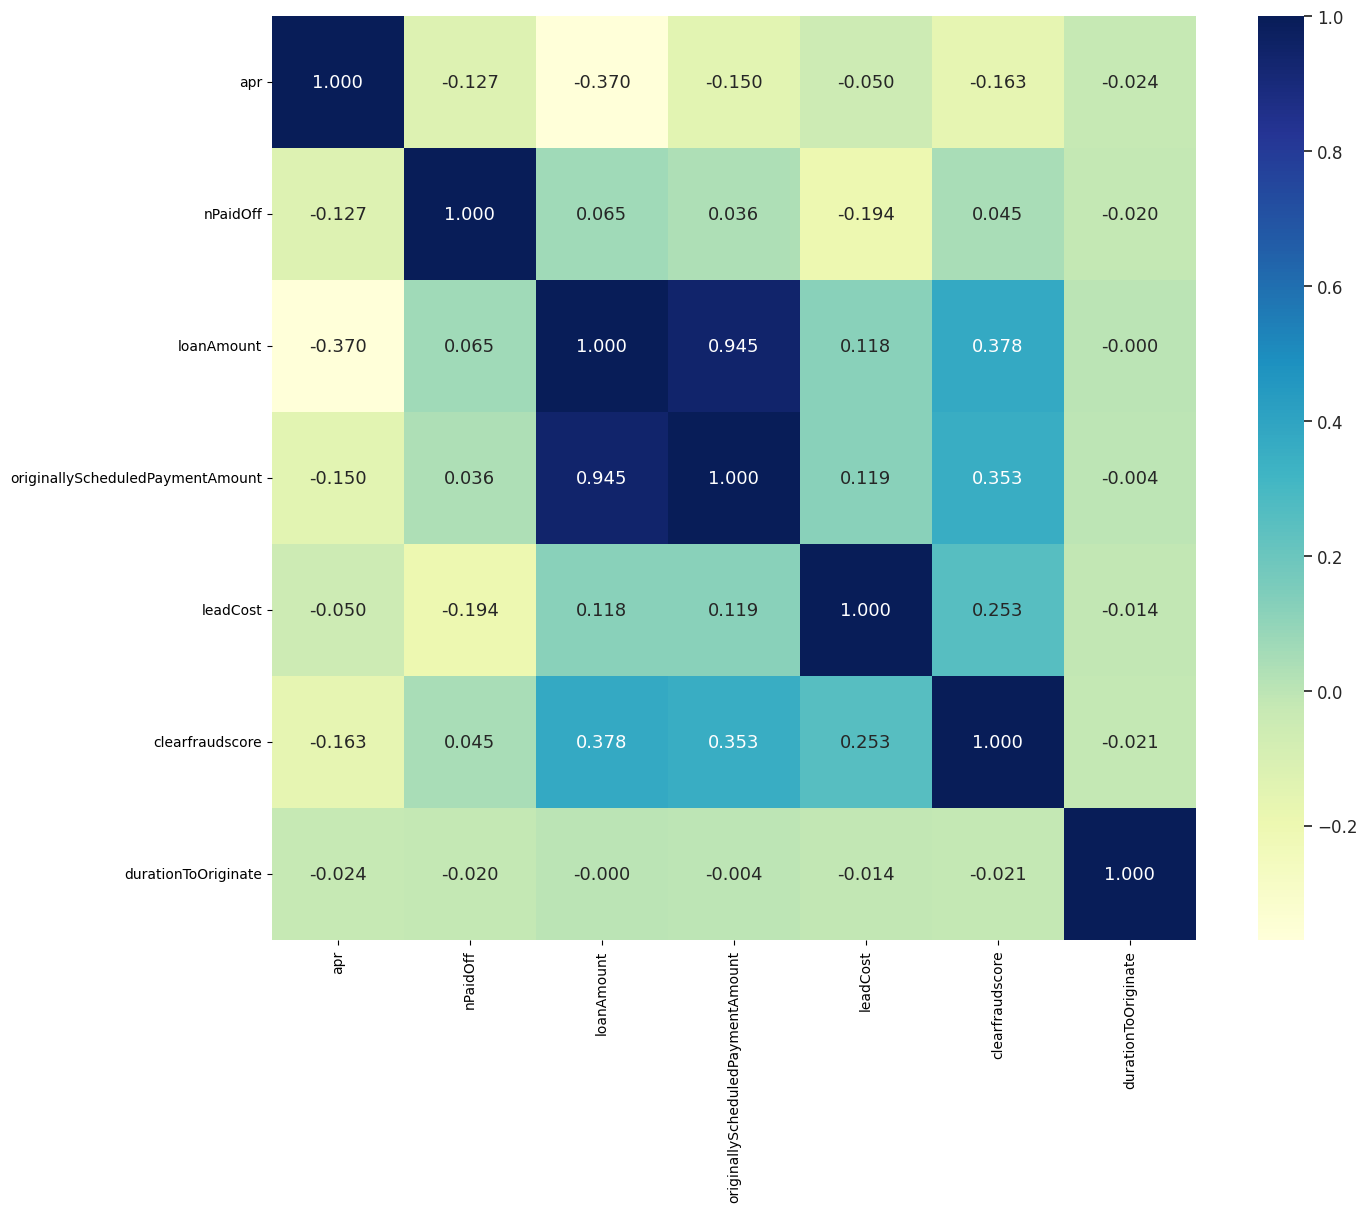

In [ ]:
def plot_cor_matrix(df, column_name):
    corrMatrix = df.loc[:, column_name].corr()

    plt.subplots(figsize=(16,12))
    sns.set_style('darkgrid')
    sns.set(font_scale=1.1)
    sns.heatmap(corrMatrix,
                annot=True,
                cmap="YlGnBu",
                fmt=".3f",
                annot_kws={'size':13},
                robust=True,
                square=True)
    plt.show()
plot_cor_matrix(merged_df, numerical_cols)

From the correlation table above, it noticed that originallyScheduledPaymentAmount is directly correlated with the loan Amount.

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.select_dtypes(include=[np.number]).columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    corr = df.select_dtypes(include=[np.number]).corr()
    au_corr = corr.abs().unstack()
    labels_to_drop = get_redundant_pairs(df.select_dtypes(include=[np.number]))
    #From corrolation table, drop the diagonals(which gives 1 corr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
#Result below show the
print("Top 5 Absolute Correlations")
print(get_top_abs_correlations(merged_df), 5)

Top 5 Absolute Correlations
loanAmount                        originallyScheduledPaymentAmount    0.944976
                                  clearfraudscore                     0.377965
apr                               loanAmount                          0.369843
originallyScheduledPaymentAmount  clearfraudscore                     0.352867
leadCost                          clearfraudscore                     0.252504
dtype: float64 5


##### Distribution of numerical data

Distribution plot can help to understand the shape of the data distribution

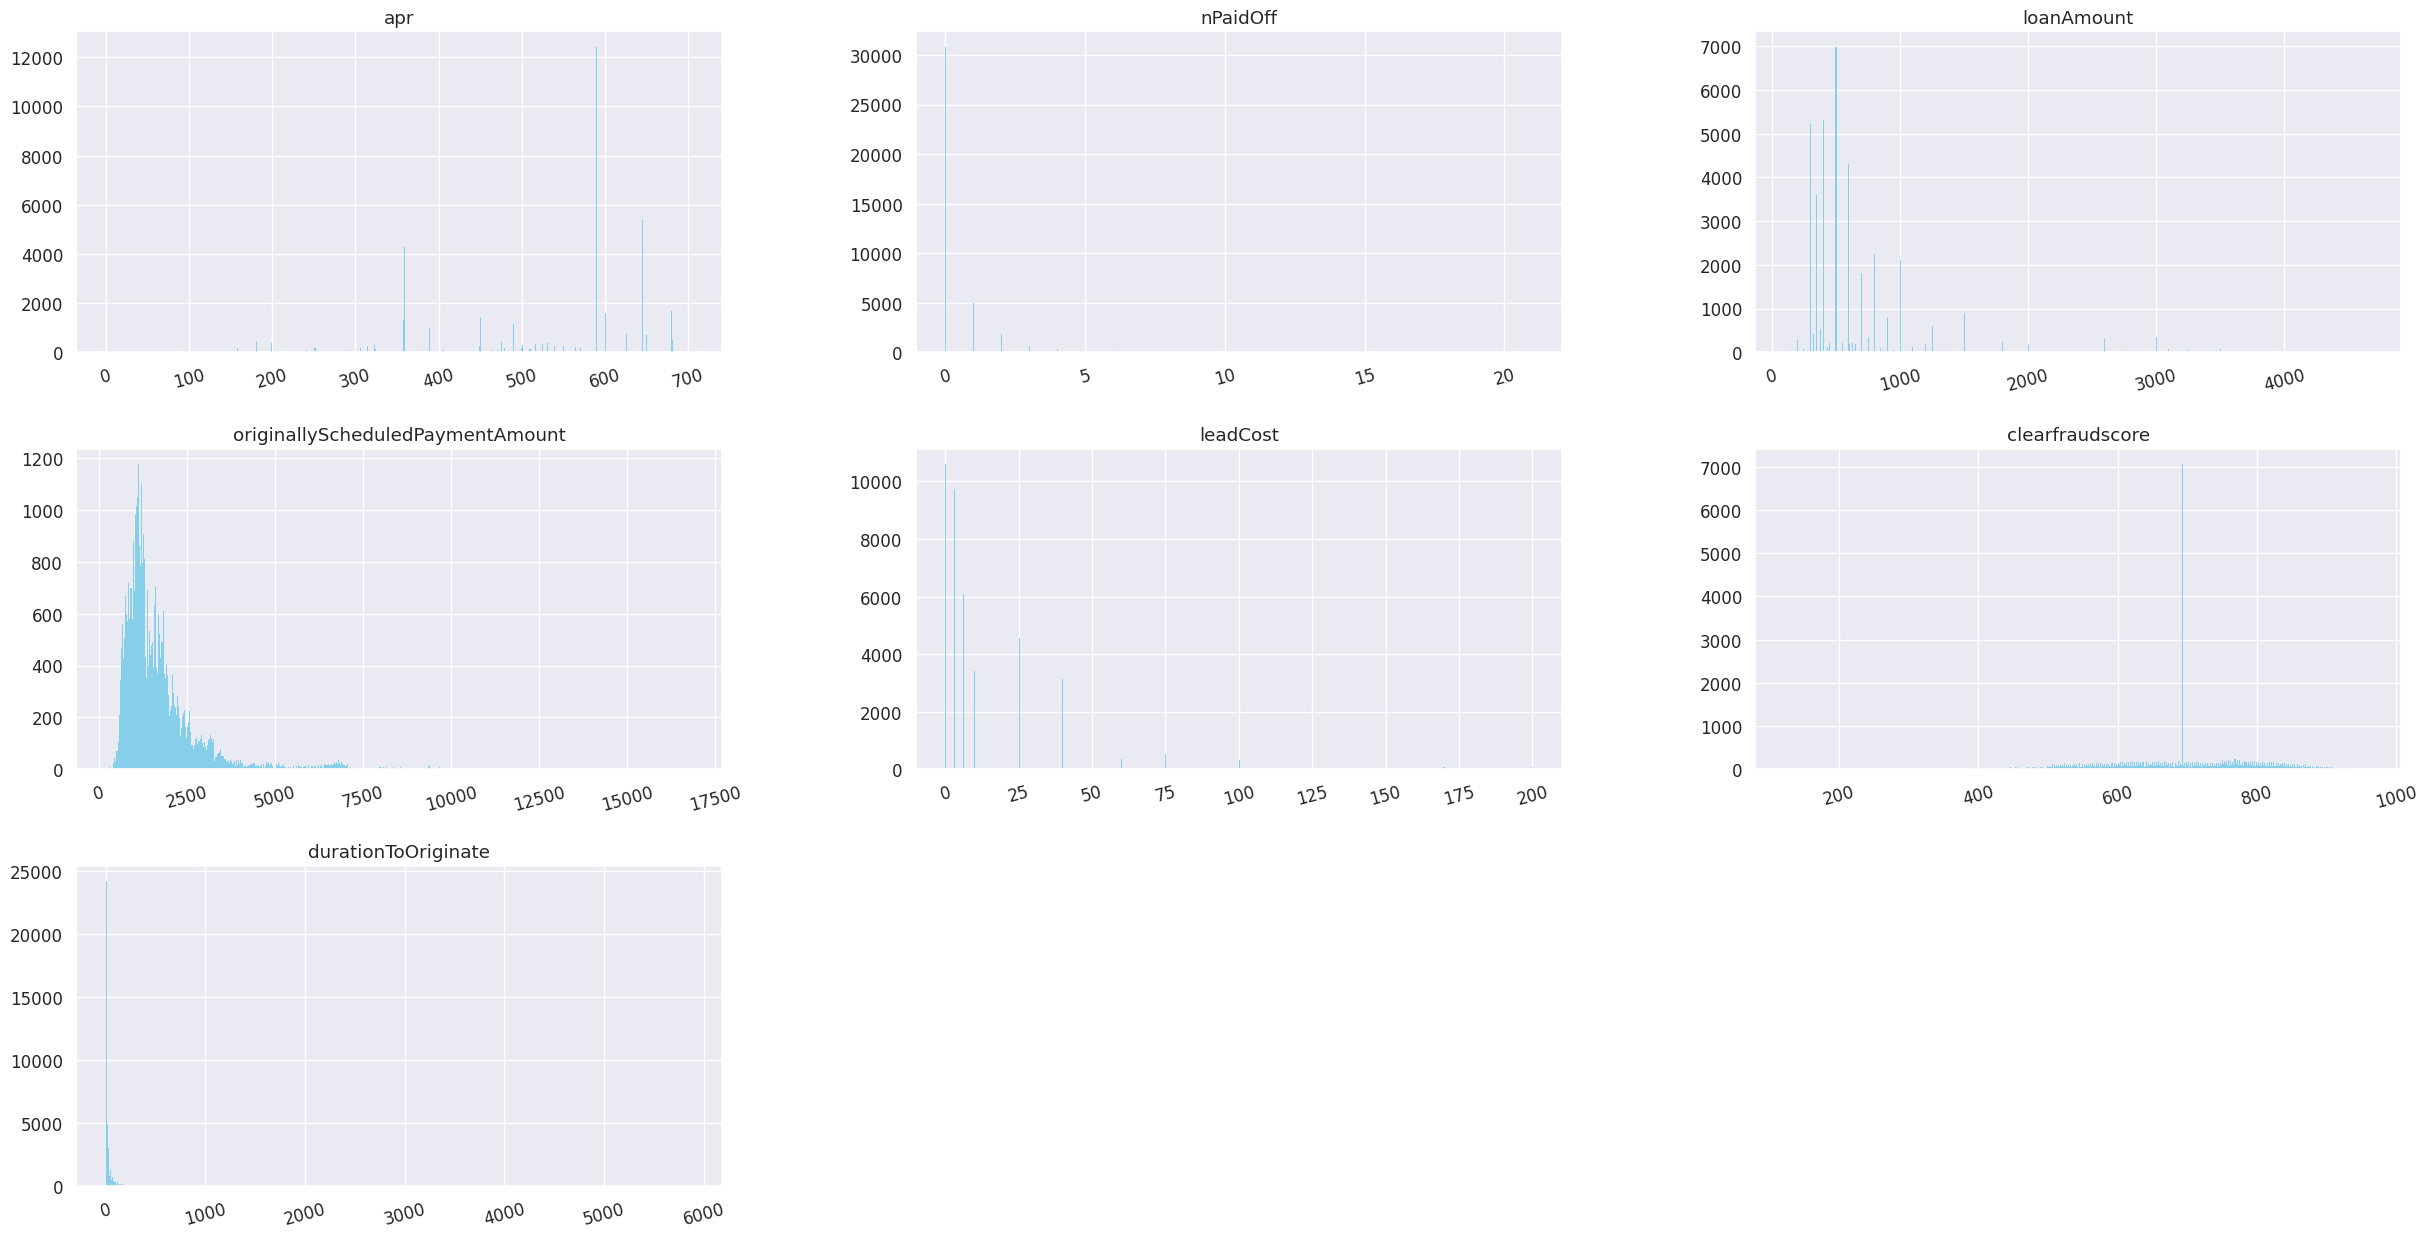

In [ ]:
#Plt histogram on numerical data
merged_df[numerical_cols].hist(figsize=(30,15), xrot=15, bins=int(merged_df.shape[0]**0.6), color = "skyblue", ec="skyblue", lw=0);

The histogram above show all the numerical data histogram graph to understand its distribution.

<ipython-input-21-d8b91c615583>:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, column], hist=True, fit=norm, ax=axes[index])
<ipython-input-21-d8b91c615583>:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, column], hist=True, fit=norm, ax=axes[index])
<ipython-input-21-d8

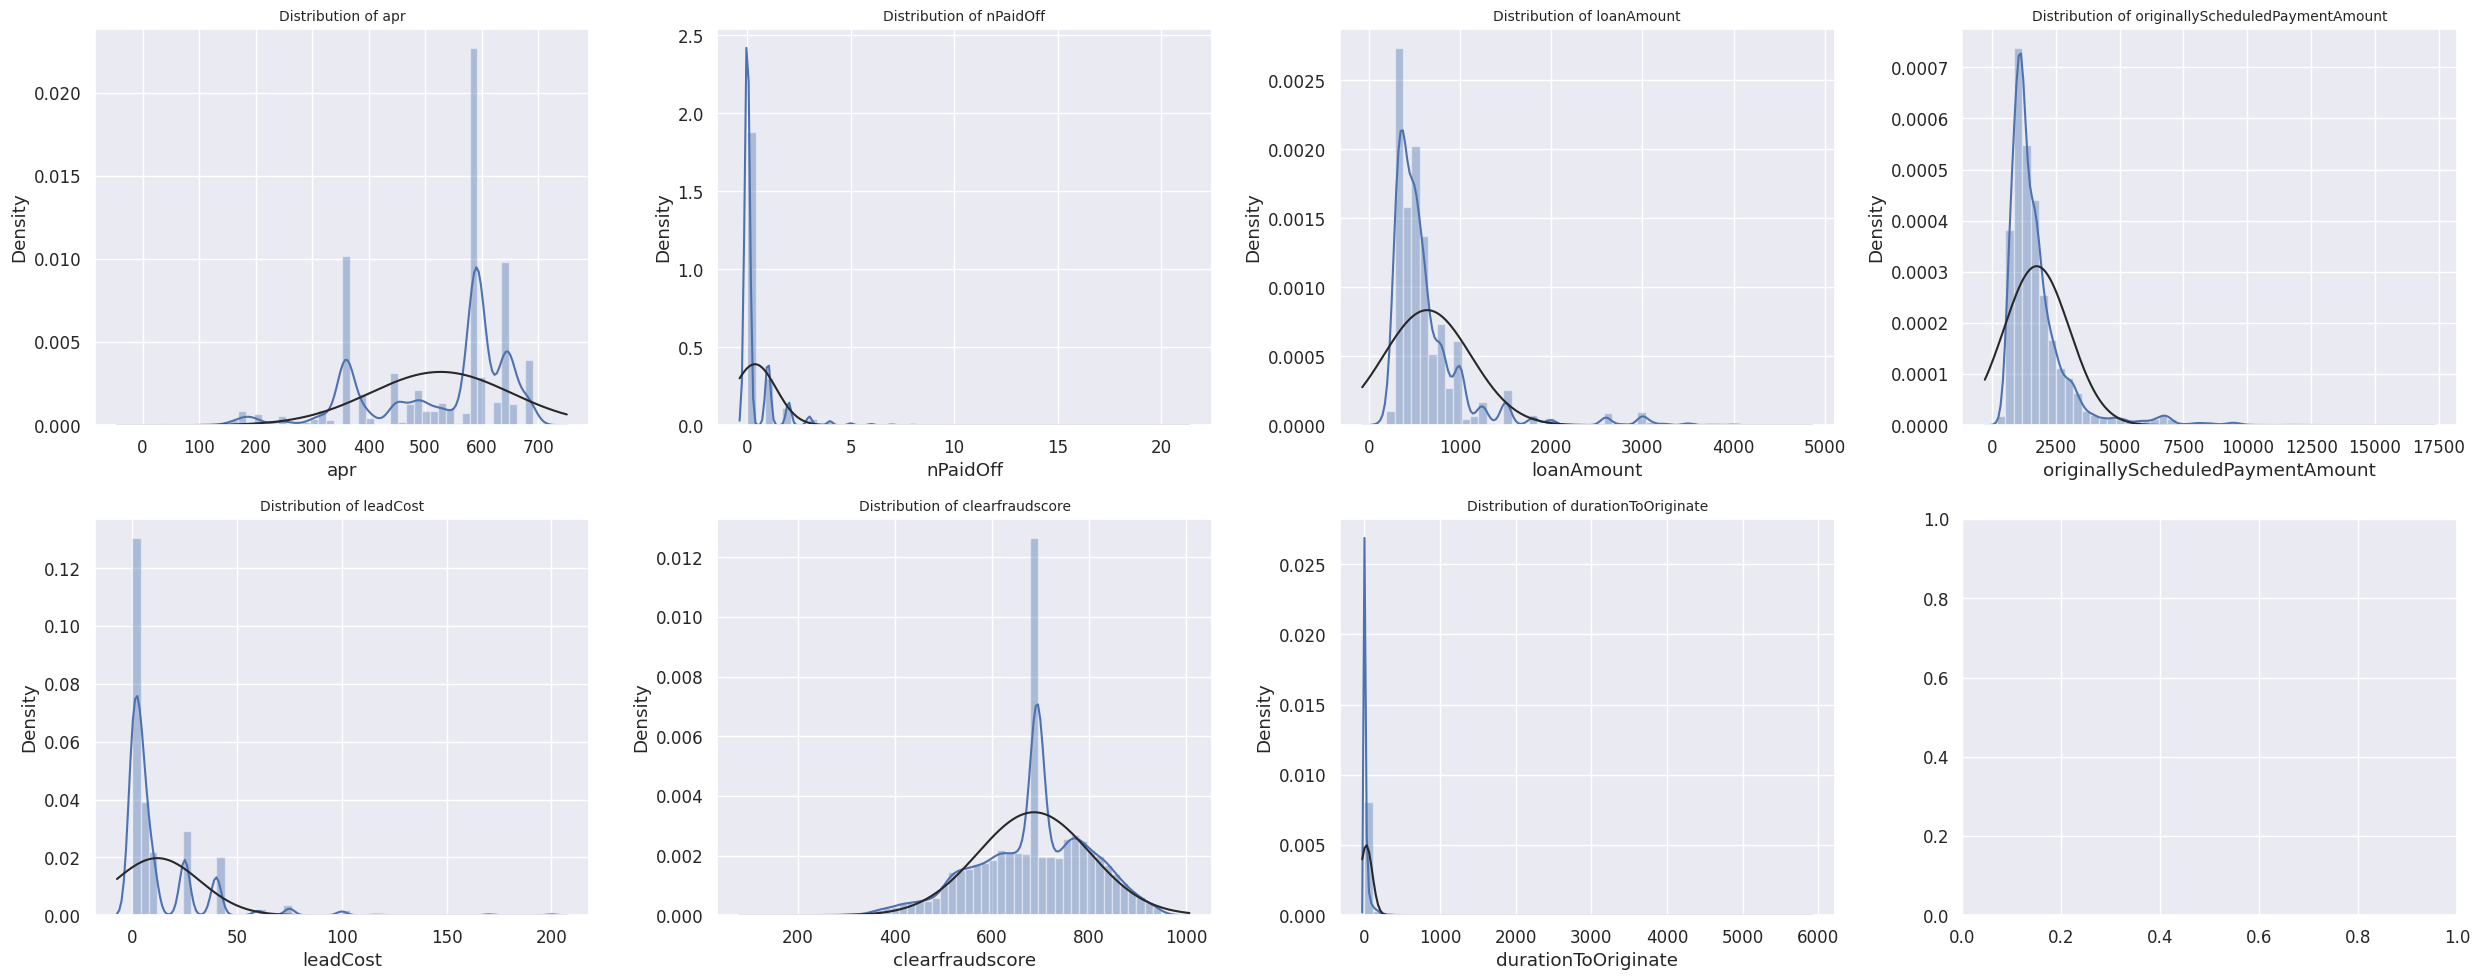

In [ ]:
import matplotlib.patheffects as path_effects
from scipy.stats import norm
import math

#Plot distribution plot on numerical column
def plotDistPlot(df, columns):
    fig, ax = plt.subplots(len(columns)//6, 6,figsize=(35, 20)) ##adjust this to set size

    index = 0
    for i in range(2):
        for j in range(3):
            sns.distplot(df.loc[:, columns[index]],
                        hist=True,
                        fit=norm,
                        kde=True,
                        ax=ax[i][j])
            ax[i][j].set_title(columns[index])
            ax[i][j].legend(labels=['Normal', 'Actual'])
            index += 1

def plot_distributions(df, selected_columns):
    num_plots = len(selected_columns)
    num_cols = 4
    num_rows = math.ceil(num_plots / num_cols)
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5*num_rows))
    # Flatten the axes array to facilitate indexing
    axes = axes.flatten()
    # Loop through selected columns and plot distributions
    for index, column in enumerate(selected_columns):
        sns.distplot(df.loc[:, column], hist=True, fit=norm, ax=axes[index])
        axes[index].set_title(f'Distribution of {column}', fontsize=10)
        axes[index].set_xlabel(column)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

plot_distributions(merged_df, numerical_cols)

In [ ]:
#float_columns = [x for x in merged_df.columns if x in merged_df.select_dtypes('number')]
#Print Sknewness if skew value exceed 0.75
print("Numerical column skewness value > 0.75")
print("======================================")
skew_columns = (merged_df[numerical_cols]
                .skew()
                .sort_values(ascending=False))
pos_skew_columns = skew_columns.loc[skew_columns > 0.75]
print(pos_skew_columns)
print("\n")
print("Numerical column skewness value < -0.75")
print("======================================")
neg_skew_columns= skew_columns.loc[skew_columns < -0.75]
print(neg_skew_columns)

Numerical column skewness value > 0.75
durationToOriginate                 25.828521
nPaidOff                             6.216157
leadCost                             3.838605
loanAmount                           3.259636
originallyScheduledPaymentAmount     3.143062
dtype: float64


Numerical column skewness value < -0.75
apr   -0.96903
dtype: float64


To have a better view, the histogram is plot with the density lines in normal and actual and . Based on the graph above, the clearfraudscore is normal distribution since its skewness value is lower than 0.75. For the column having greater than 0.75 or low than -0.75 will be consider for a moderate skewness. The durationToOriginate, nPaidOff, leadCost, loanAmount and originallyScheduledPaymentAmount are right skew, while the apr is on left skew.

##### Box plot on numerical data

Box plot can help to provide better view of skewness and the outlier

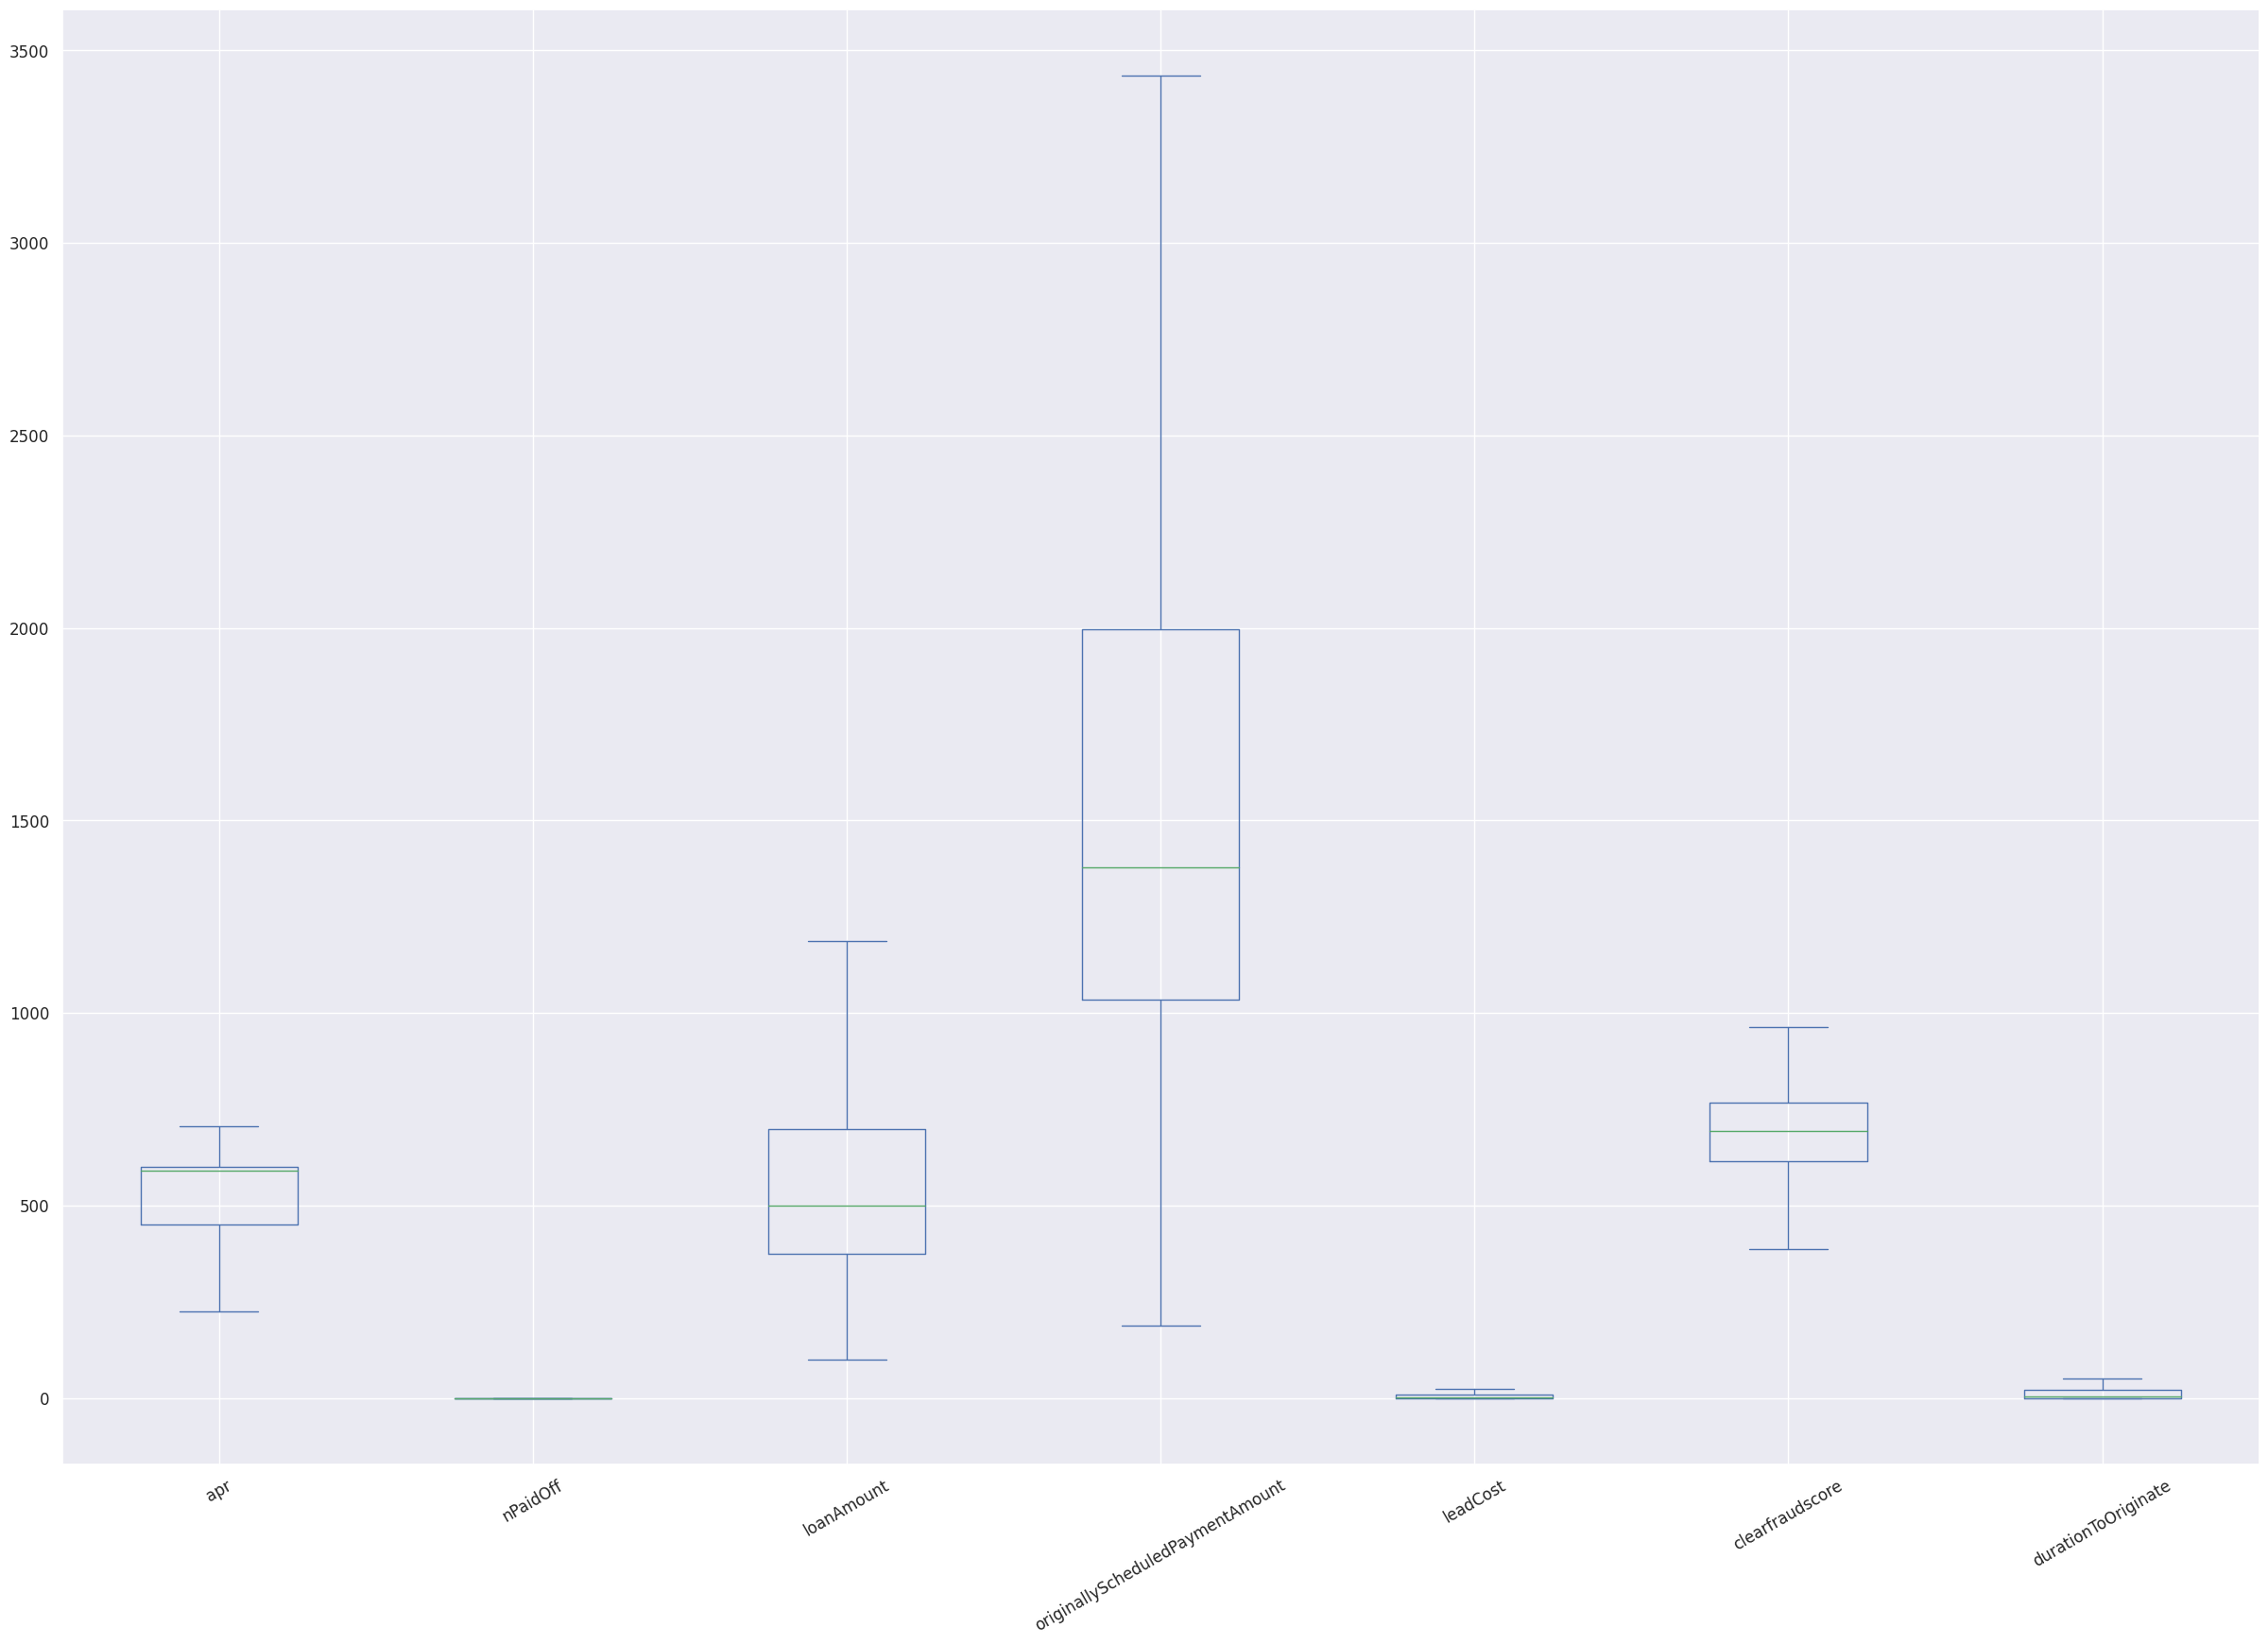

In [ ]:
merged_df[numerical_cols].plot(kind='box', figsize = (30,20), rot=30, showfliers=False);

The chart above show the rough box plot for the numerical column.

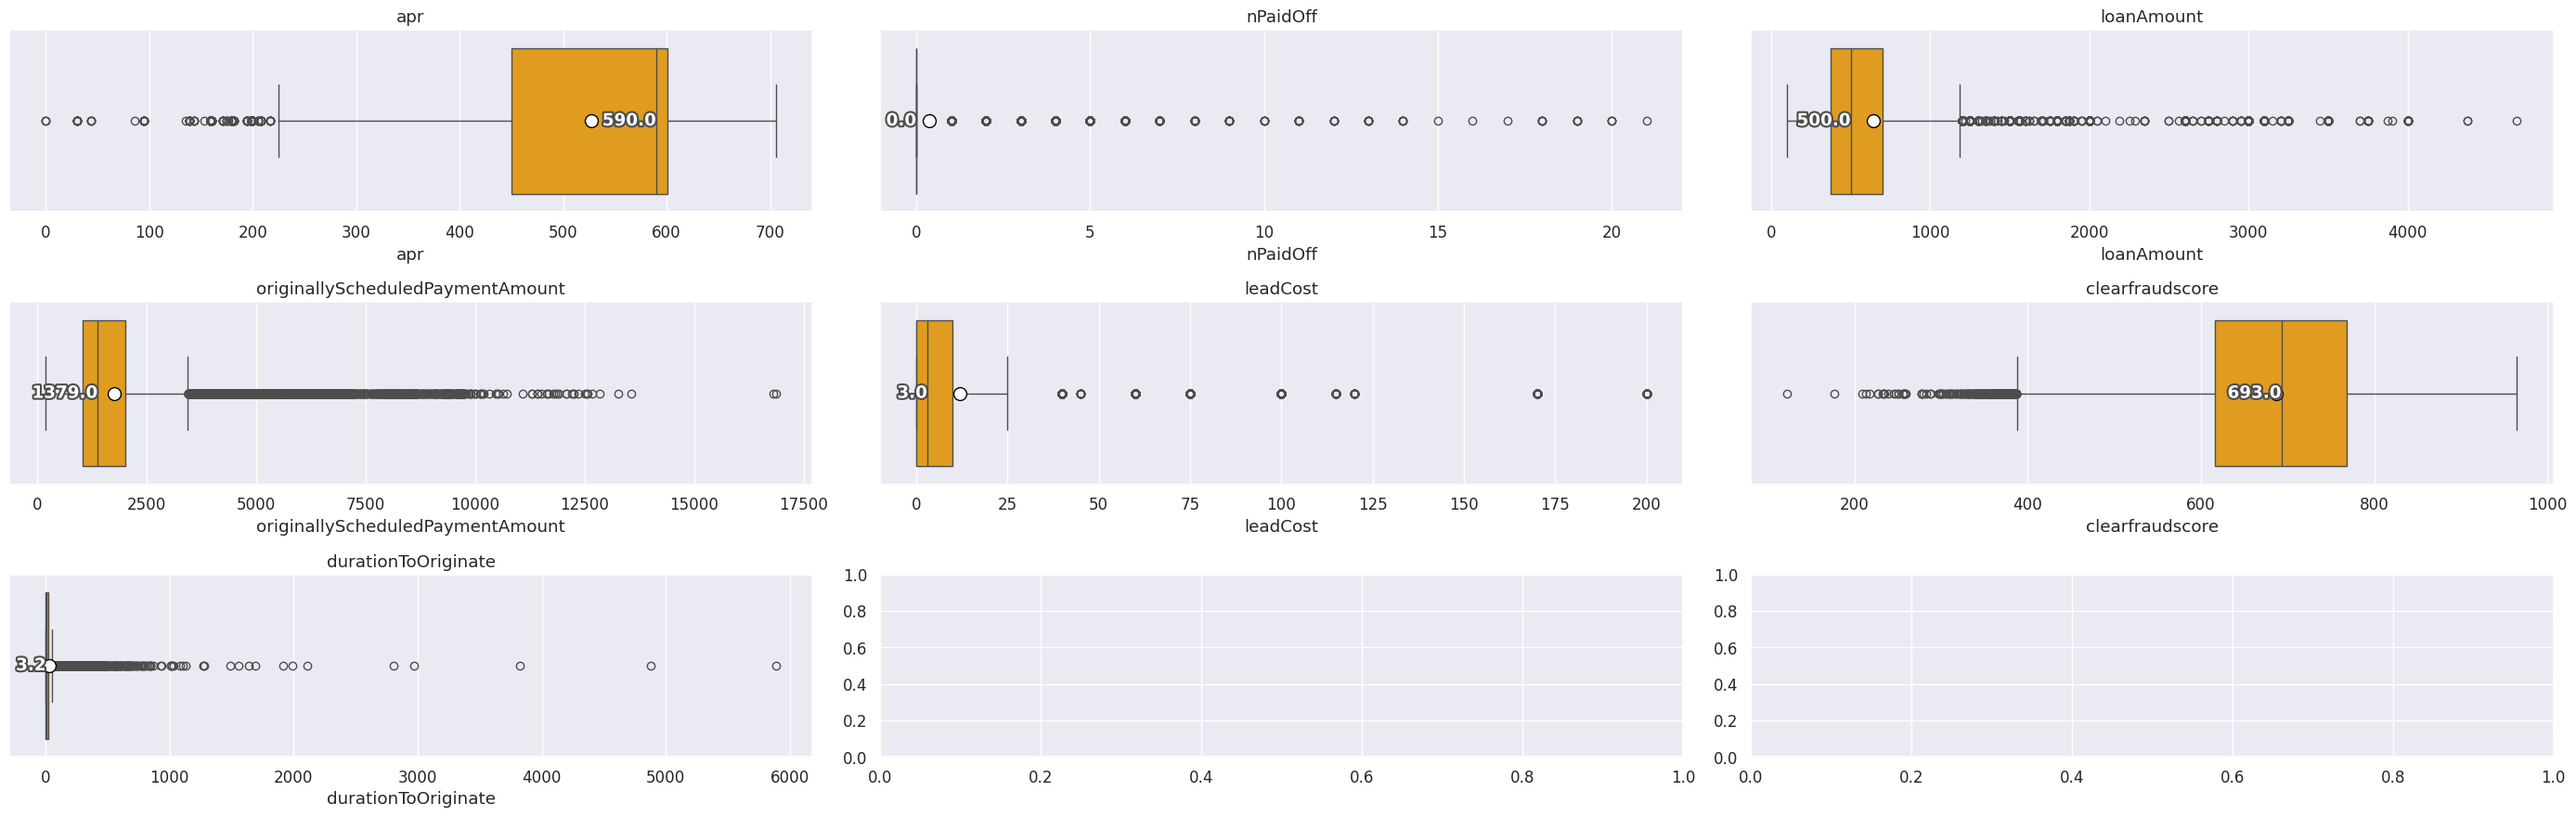

Column 'apr': 1097 outliers, 2.81% of data.
Column 'nPaidOff': 8148 outliers, 20.90% of data.
Column 'loanAmount': 3245 outliers, 8.32% of data.
Column 'originallyScheduledPaymentAmount': 2560 outliers, 6.57% of data.
Column 'leadCost': 4539 outliers, 11.64% of data.
Column 'clearfraudscore': 373 outliers, 0.96% of data.
Column 'durationToOriginate': 4628 outliers, 11.87% of data.


In [ ]:
#Show mean value on box plot
def add_median_labels(ax):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:.1f}', ha='right', va='center',
                       fontweight='bold', color='white')
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

# plot Box Plot
def show_box_plot(df, columns):
    num_plots = len(columns)
    num_rows = int(np.ceil(num_plots / 3))
    fig, ax = plt.subplots(num_rows, 3, figsize=(28, num_rows * 3))

    for i in range(num_rows):
        for j in range(3):
            index = i * 3 + j
            if index < num_plots:
                agePlot = sns.boxplot(df.loc[:, columns[index]],
                                      color='orange', showmeans=True,
                                      meanprops={"marker": "o",
                                                 "markerfacecolor": "white",
                                                 "markeredgecolor": "black",
                                                 "markersize": "10"},
                                      ax=ax[i, j], orient='h')
                add_median_labels(agePlot.axes)
                ax[i, j].set_title(columns[index])

    plt.tight_layout()
    plt.show()

def count_outliers(df, columns):
    for column in columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in the DataFrame.")
            continue
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        num_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        percentage_outliers = (num_outliers / len(df)) * 100
        print(f"Column '{column}': {num_outliers} outliers, {percentage_outliers:.2f}% of data.")


show_box_plot(merged_df, numerical_cols)
count_outliers(merged_df, numerical_cols)

The box plot provide a better view on the outlier for each numerical columns. Based on the graph and count result, it notice that there are quite alot of outlier in loanAmount, nPaidOff, leadCost, originallyScheduledPaymentAmount, clearfraudscore and durationToOriginate. The outlier will be handle in futher step before training the model.

#### Categorical Data analysis

##### Count plot

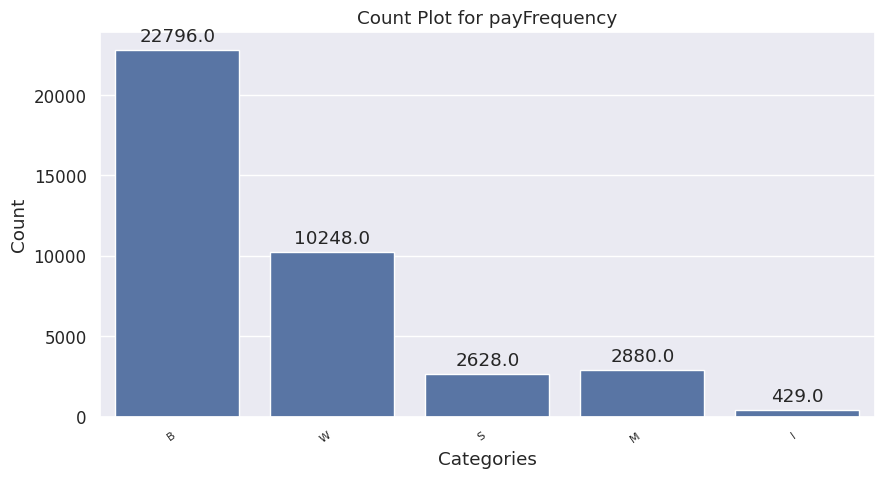

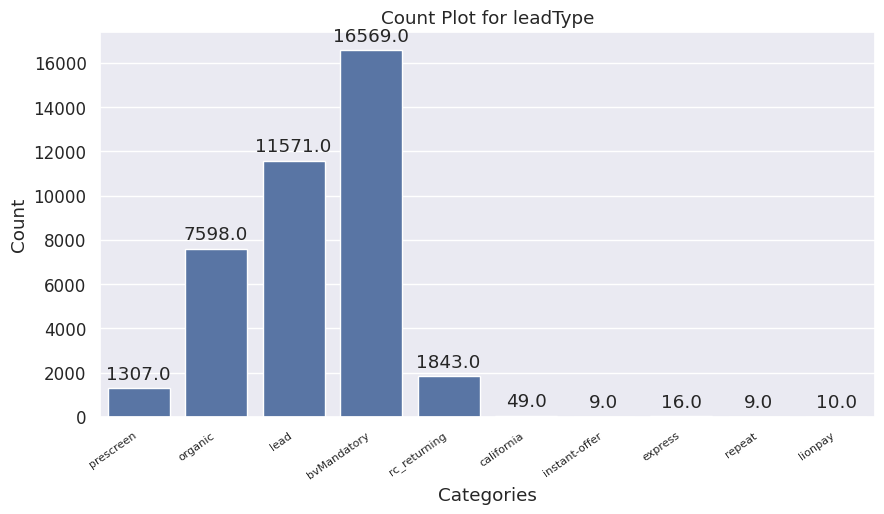

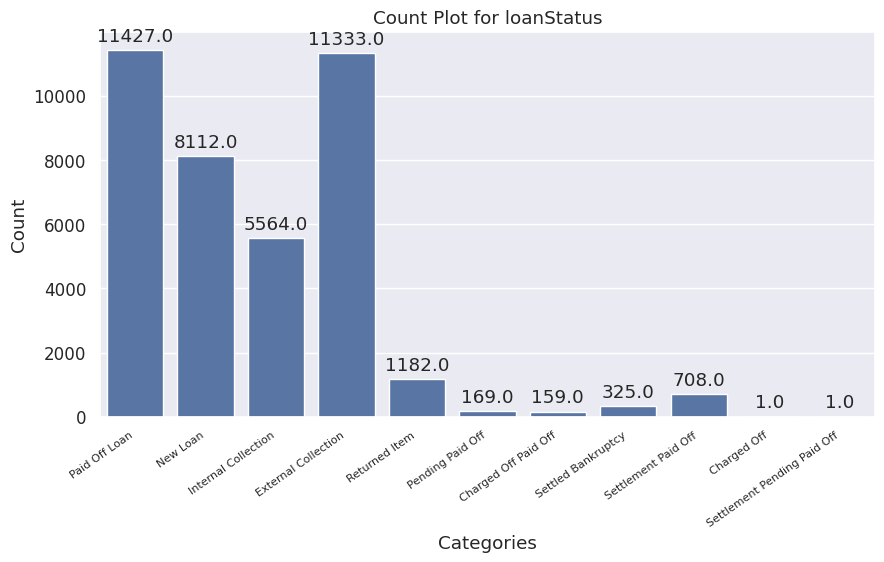

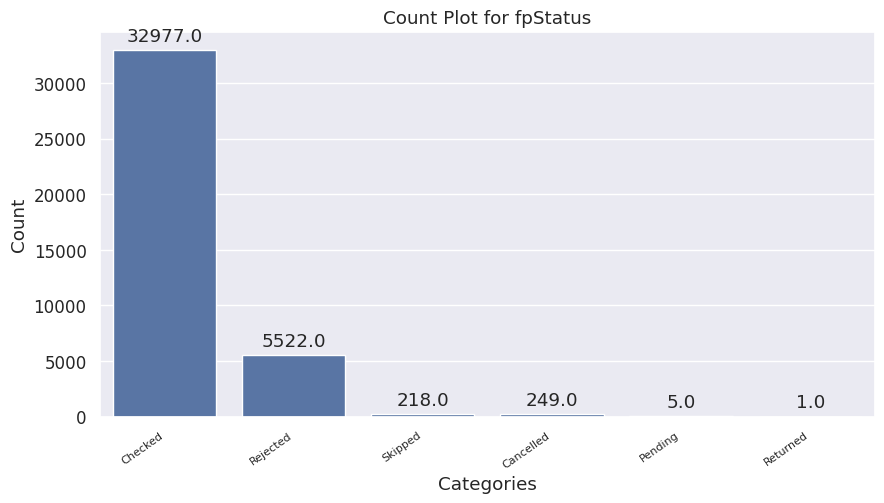

In [ ]:
# Plot categorical columns
def show_count_plot(df, categorical_columns):
    for column in categorical_columns:
        if df[column].dtype == 'O':  # Check if the column is of object (string) type
            plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
            ax = sns.countplot(x=column, data=df)

            # Display count values on top of each bar
            for p in ax.patches:
                ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 10), textcoords='offset points')
            plt.xticks(fontsize=8, rotation=35, ha="right")
            plt.title(f'Count Plot for {column}')
            plt.xlabel('Categories')
            plt.ylabel('Count')
            plt.show()
col_to_remove = ['loanId', 'anon_ssn', 'state','applicationDate', 'originatedDate']
selected_categorical_cols = [col for col in categorical_cols if col not in col_to_remove]
#print(selected_categorical_cols)
show_count_plot(merged_df, selected_categorical_cols)

The count plot above had visualize the total number of count for each value in respective column. After look through the column, the loanStatus will be good to act as the target variable to predict whether it is good or bad loan.

In [ ]:
merged_df['loanStatus'].value_counts(normalize=True) * 100

Paid Off Loan                  29.314281
External Collection            29.073138
New Loan                       20.810138
Internal Collection            14.273620
Returned Item                   3.032246
Settlement Paid Off             1.816269
Settled Bankruptcy              0.833740
Pending Paid Off                0.433545
Charged Off Paid Off            0.407891
Charged Off                     0.002565
Settlement Pending Paid Off     0.002565
Name: loanStatus, dtype: float64



The loanStatus above can be cateorized into 3 category which is good loan, bad loan and others. The good quality loans are usually having the status like, Paid Off Loan and Settlement Paid Off .

While the example of loans that having bad quality are  Charged Off and Settled Bankruptcy. The other status will be categorized as others because it hard/meaningless to identify as good or bad loans since the loan still ongoing.

##### Define Target

In [ ]:
def encode_status(row_value):
    target_labels = {0: ['Charged Off', 'Settled Bankruptcy'],
                     1: ['Paid Off Loan', 'Settlement Paid Off'] #, 'Pending Paid Off' and Pending Paid Off(My assumention, payment has been is in progress but has not yet been fully processed)
                    }
    for label, values in target_labels.items():
        if row_value in values:
            return label

merged_df['isGoodLoan'] = merged_df['loanStatus'].apply(lambda x: encode_status(x))
merged_df = merged_df[merged_df['isGoodLoan'].notna()].reset_index(drop=True)
# Display results
merged_df['isGoodLoan'].value_counts(normalize=True) * 100

1.0    97.383838
0.0     2.616162
Name: isGoodLoan, dtype: float64

In [ ]:
selected_category_cols= ["isGoodLoan", "leadType", "fpStatus"]

def count_categorical_values(df, column_list):
    for column in column_list:
        value_counts = df[column].value_counts().reset_index()
        value_counts.columns = [column, 'Count']
        value_counts['Percentage'] = (value_counts['Count'] / len(df)) * 100
        print(f"\nColumn: {column}")
        print(value_counts)

count_categorical_values(merged_df, selected_category_cols)


Column: isGoodLoan
   isGoodLoan  Count  Percentage
0         1.0  12135   97.383838
1         0.0    326    2.616162

Column: leadType
        leadType  Count  Percentage
0    bvMandatory   4864   39.033785
1        organic   3610   28.970388
2           lead   2772   22.245406
3   rc_returning    635    5.095899
4      prescreen    528    4.237220
5     california     26    0.208651
6        lionpay     10    0.080250
7        express      9    0.072225
8         repeat      6    0.048150
9  instant-offer      1    0.008025

Column: fpStatus
    fpStatus  Count  Percentage
0    Checked  11840   95.016451
1   Rejected    349    2.800738
2  Cancelled    208    1.669208
3    Skipped     64    0.513602


By printing the result, it notice that the target variable are imbalance. The issues while be handle in next stage.

In [ ]:
merged_df.head()

loanId                          anon_ssn payFrequency    apr  \
0  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
1  LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0   
2  LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   
3  LL-I-09279047  1d249e27292d25e4d3b4bc142a2a4aea            W  404.1   
4  LL-I-01316580  2a10b2e04c5eec9a47a8cf5b9b81a2b8            W  590.0   

          applicationDate          originatedDate  nPaidOff     loanStatus  \
0 2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0  Paid Off Loan   
1 2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0  Paid Off Loan   
2 2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0  Paid Off Loan   
3 2016-05-25 03:05:18.849 2016-05-25 15:11:36.260       3.0  Paid Off Loan   
4 2015-05-26 17:02:27.312 2015-05-26 18:45:48.024       0.0  Paid Off Loan   

   loanAmount  originallyScheduledPaymentAmount state     leadType  leadCost  \
0      3000.0                           6395.19    CA    prescreen         0   
1      1250.0                           3313.78    MO      organic         0   
2       800.0                           2432.08    CA  bvMandatory        10   
3       300.0                            422.64    WI      organic         0   
4       300.0                            896.87    MO  bvMandatory         6   

   fpStatus  clearfraudscore  durationToOriginate  isGoodLoan  
0   Checked            879.0            17.695019         1.0  
1   Checked            835.0             0.199205         1.0  
2   Checked            624.0            53.949603         1.0  
3   Checked            770.0            12.104836         1.0  
4  Rejected            693.0             1.722420         1.0

##### Crosstab plot
After define the target variable, we now plot the crosstab

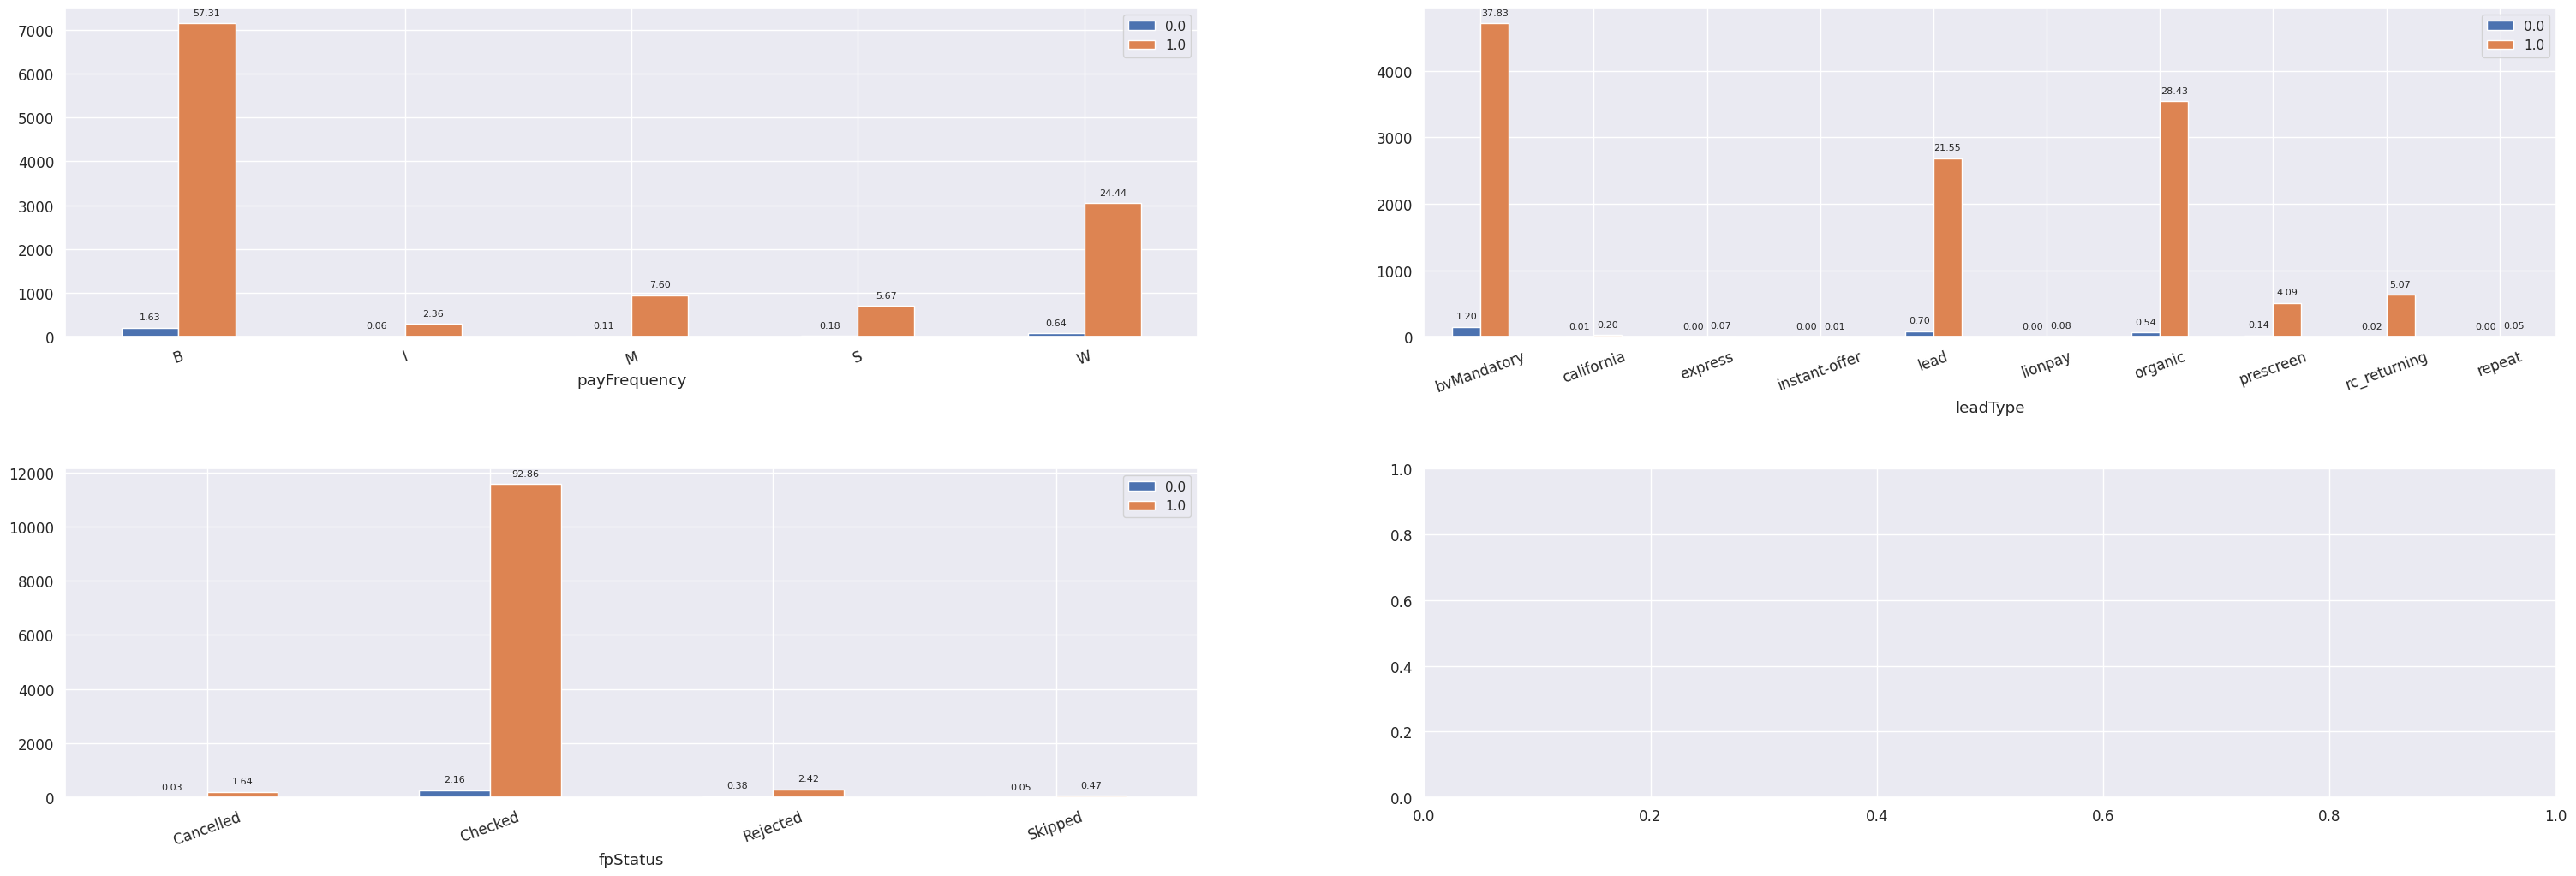

In [ ]:
def plot_crosstab(df, cat, target_column):
    ## do after define Y label

    num_rows = (len(cat) // 2) + (1 if len(cat) % 2 != 0 else 0)
    num_cols = min(len(cat), 2)

    fig, axis = plt.subplots(num_rows, num_cols, figsize=(30, 5 * num_rows))
    fig.tight_layout()

    index = 0
    sns.set()
    for i in range(num_rows):

        for j in range(num_rows):

            # Since we have 11 numerical columns, some plots will be empty
            if index == len(cat):
                break
            ax = pd.crosstab(df[cat[index]], df[target_column]).plot(kind='bar', ax=axis[i][j])

            for item in ax.get_xticklabels():
                item.set_rotation(20)

            for p in ax.patches:
                ax.annotate(format(p.get_height()/len(df)*100, '.2f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=8)

            index += 1
            ax.legend(loc="best")

    plt.subplots_adjust(wspace=0.2, hspace=0.4)

col_to_remove = ['loanId', 'anon_ssn', 'state','applicationDate', 'originatedDate', 'loanStatus']
selected_categorical_cols = [col for col in categorical_cols if col not in col_to_remove]
plot_crosstab(merged_df, selected_categorical_cols, 'isGoodLoan')


Based on the crosstab plot above, we notice that the 'bvMandatory' lead type has the hightest number of bad and good loans among others. The 'lead' lead type has having lower good loan quantity but a higher number of bad loans compared to 'organic' type.

For fpStatus, the majority of the loans are 'Checked'(first payment success) and the majority are good loans. For the payment frequency, most of the loans are chosen to be paid in 'B'(biweekly payment) followed by 'W'(weekly).

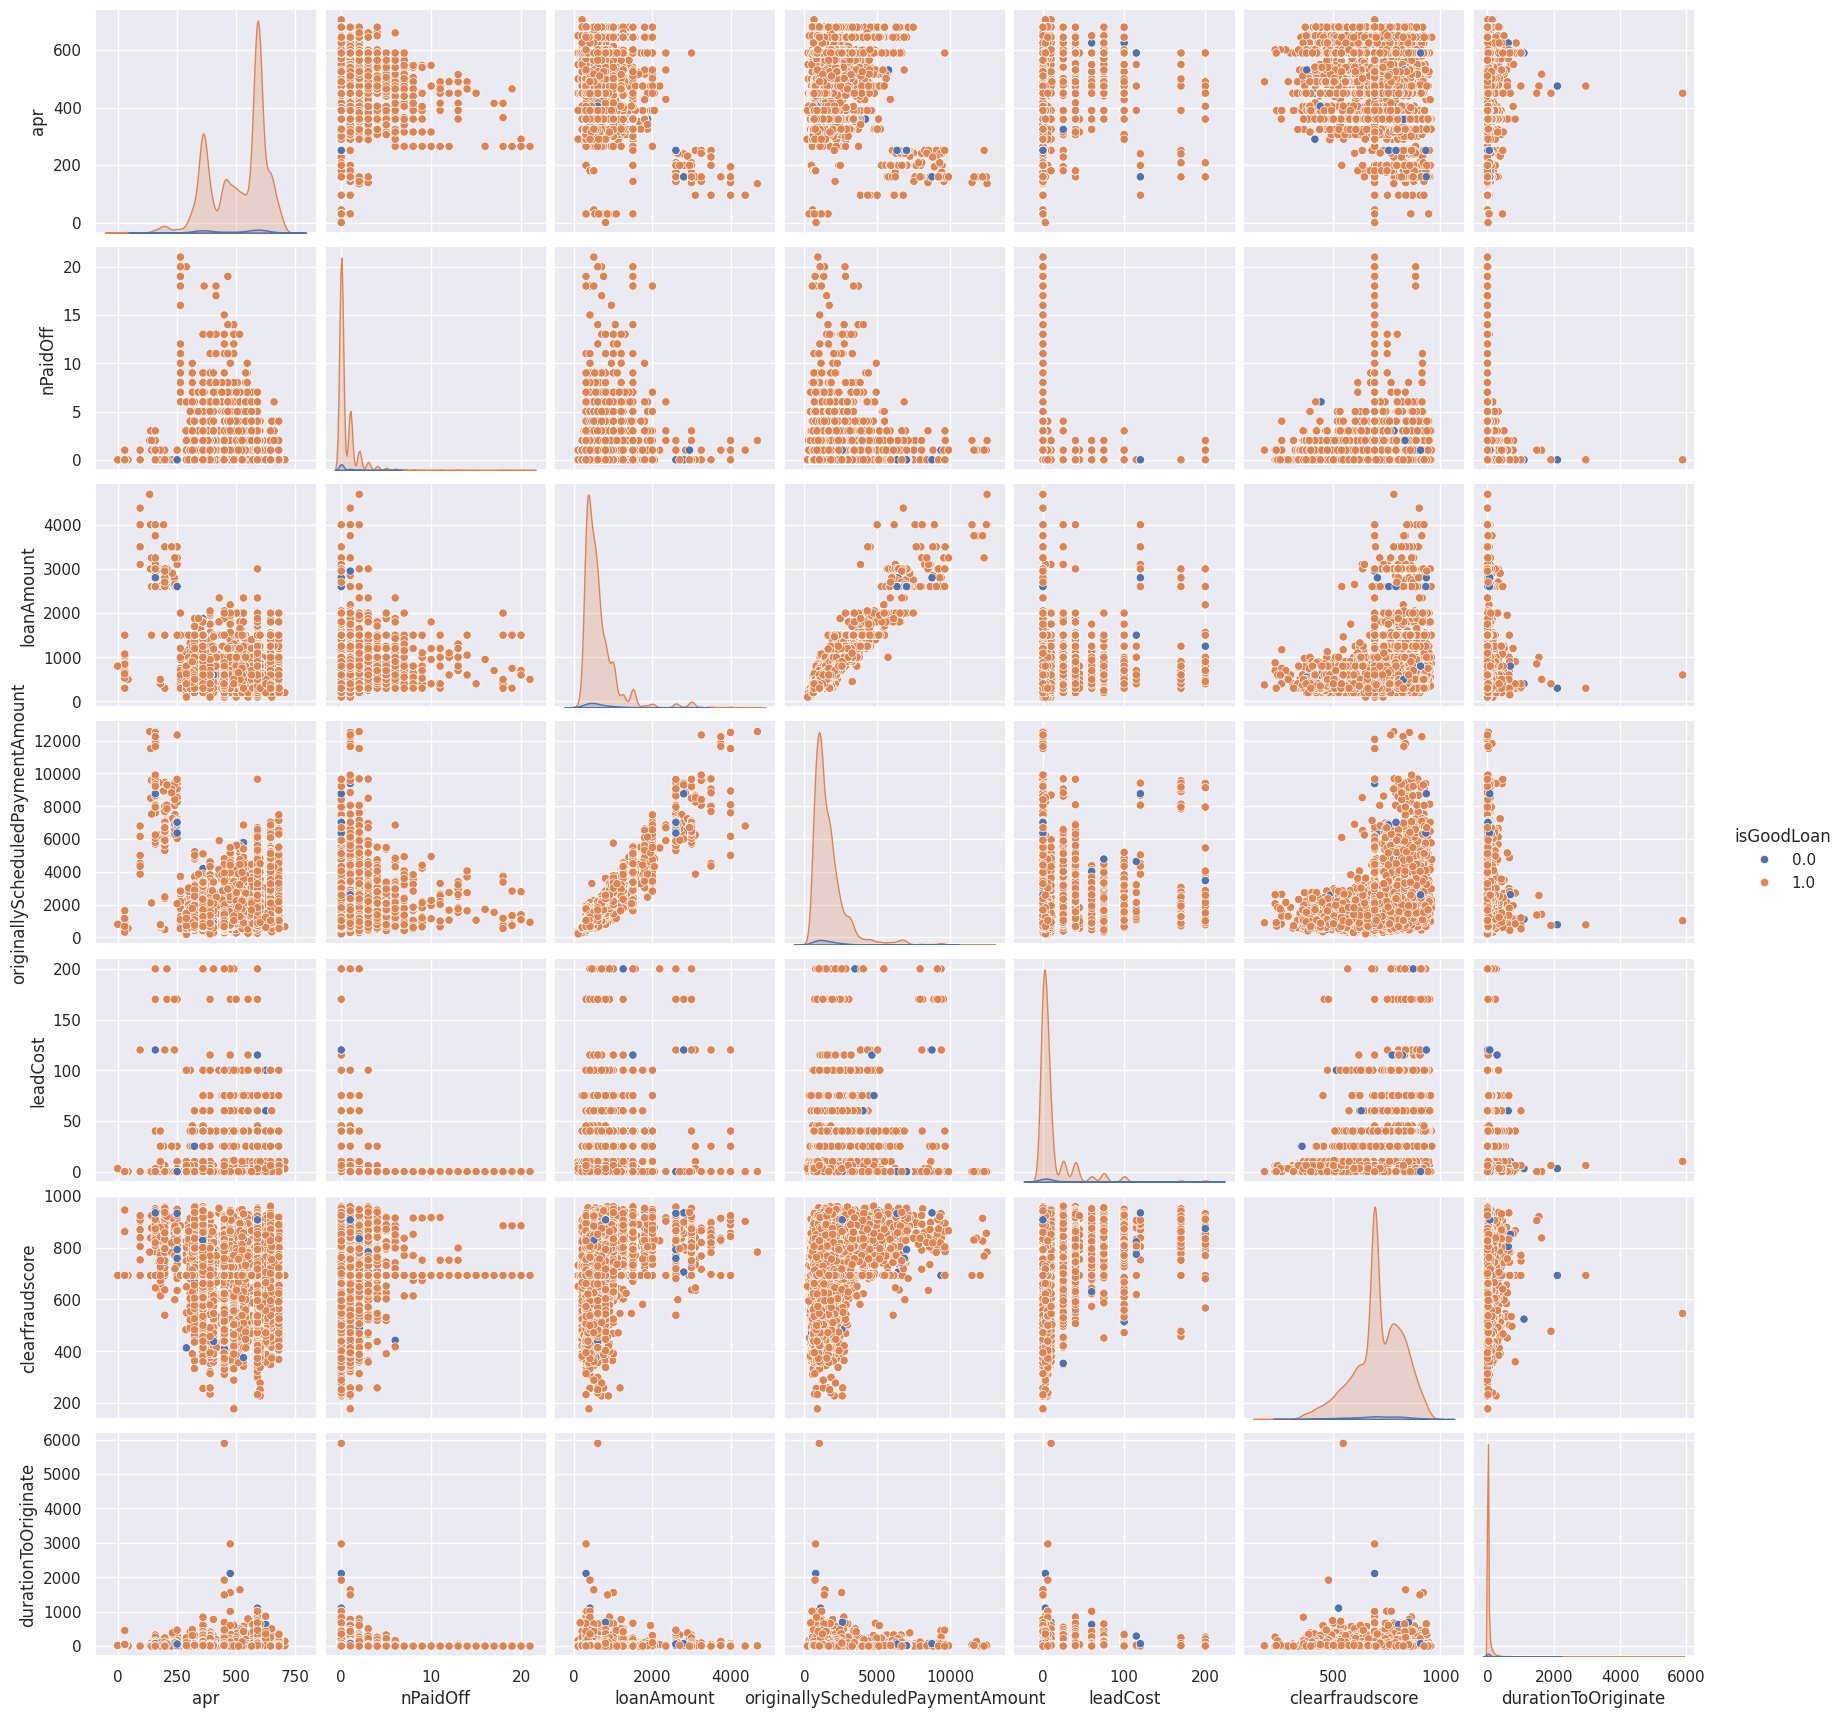

In [ ]:
def plot_pair_plot(df, columns, target_column):
    sns.pairplot(df[columns], hue=target_column)
    plt.show()

col_to_remove = ['loanId', 'anon_ssn', 'state','applicationDate', 'originatedDate', 'loanStatus']
selected_cols = [col for col in merged_df.columns.tolist() if col not in col_to_remove]
plot_pair_plot(merged_df, selected_cols, 'isGoodLoan')

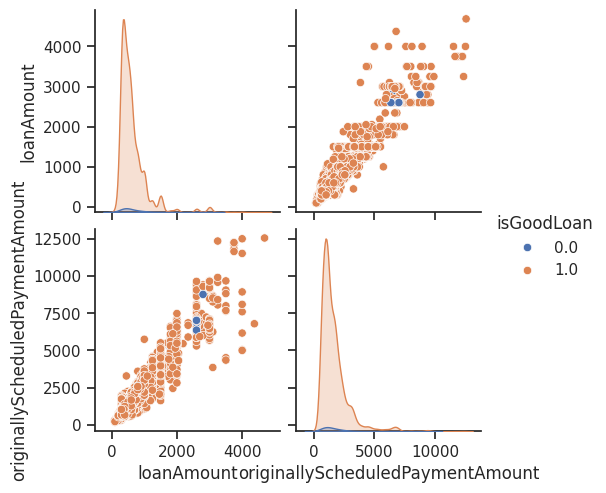

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(merged_df,vars =["loanAmount","originallyScheduledPaymentAmount"],hue='isGoodLoan')

By observing the pair plot above between loan amount and ScheduledPaymentAmount, we know that this two attribute are highly correlated. The higher the loan amountt, the higher the scheduled payment amount. Althought both attributes are highly correlated to each other, we observed that this two attibutes does not seperate good loan and bad loan well.

## Data Preparation


### Normalizing Numerical Data

Before going to modeling, scaling the numerical features can help to improve the performance of the algorithm.

Lets view the data again before started transform


In [ ]:
selected_columns = ["loanAmount", "originallyScheduledPaymentAmount", "leadCost", "clearfraudscore", "nPaidOff" , "apr", "durationToOriginate"]
merged_df[selected_columns].describe()

loanAmount  originallyScheduledPaymentAmount      leadCost  \
count  12461.000000                      12461.000000  12461.000000   
mean     629.297007                       1661.688210     12.109863   
std      451.761168                       1202.830803     24.749500   
min      100.000000                        188.410000      0.000000   
25%      350.000000                        950.230000      0.000000   
50%      500.000000                       1303.620000      3.000000   
75%      700.000000                       1943.700000     10.000000   
max     4687.000000                      12550.080000    200.000000   

       clearfraudscore      nPaidOff           apr  durationToOriginate  
count     12461.000000  12461.000000  12461.000000         12461.000000  
mean        709.577482      0.590081    508.946662            29.744810  
std         115.983220      1.389716    117.319897            95.858849  
min         177.000000      0.000000      0.000000             0.000116  
25%         655.000000      0.000000    390.000000             0.802254  
50%         693.000000      0.000000    565.000000             5.201669  
75%         794.000000      1.000000    590.000000            23.199617  
max         961.000000     21.000000    705.590000          5888.781163

In [ ]:
minmax_scaler = MinMaxScaler()
merged_df[["loanAmount", "originallyScheduledPaymentAmount"]] = minmax_scaler.fit_transform(merged_df[["loanAmount", "originallyScheduledPaymentAmount"]])

standard_scaler = StandardScaler()
merged_df[["clearfraudscore"]] = standard_scaler.fit_transform(merged_df[["clearfraudscore"]])

#boxcox_scaler = PowerTransformer(method='box-cox')
#merged_df[["leadCost"]] = boxcox_scaler.fit_transform(merged_df[["leadCost", "nPaidOff", "apr"]])
selected_columns = ["leadCost", "apr", "durationToOriginate", "nPaidOff"]
for col in selected_columns:
  merged_df[col], _ = boxcox(merged_df[col] + 1)


In the EDA stage, we know that loanAmount, originallyScheduledPaymentAmount do not have much outlier, therefore MinMax scaler will be used to scale the data. Robust Scaler will not be considered cause it may lead to a negative value which may cause the feature to become not meaningful.

The Standard Scaler scaler will be applied to clearfraudscore since it is normally distributed and only around 3% of outliers. StandardScaler is less likely to alter the original distribution shape.

The leadCost, apr, durationToOriginate and nPaidOff will use the box-cox scaler to scale the data because the box-cox is useful when dealing with skewness data.

In [ ]:
merged_df[selected_columns].describe()

leadCost            apr  durationToOriginate      nPaidOff
count  12461.000000   12461.000000         12461.000000  12461.000000
mean       1.112741  362877.609662             1.576587      0.108256
std        0.975049  156529.356367             1.046124      0.162153
min        0.000000       0.000000             0.000116      0.000000
25%        0.000000  191396.639340             0.558477      0.000000
50%        1.192430  426655.955701             1.552018      0.000000
75%        1.857130  468553.313868             2.416025      0.328587
max        3.109518  690069.406825             4.355199      0.398473

In [ ]:
### To chk infinity in column
#for column_name in selected_columns:
#    has_infinity = np.isinf(merged_df[column_name]).any()
#    if has_infinity:
#        print(f"Column '{column_name}' contains infinity values.")
#
#rows_with_infinity = merged_df[merged_df.isin([np.inf, -np.inf]).any(axis=1)]
#
#print("Rows with Infinity Values:")
#print(rows_with_infinity)

<ipython-input-21-d8b91c615583>:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, column], hist=True, fit=norm, ax=axes[index])
<ipython-input-21-d8b91c615583>:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, column], hist=True, fit=norm, ax=axes[index])
<ipython-input-21-d8

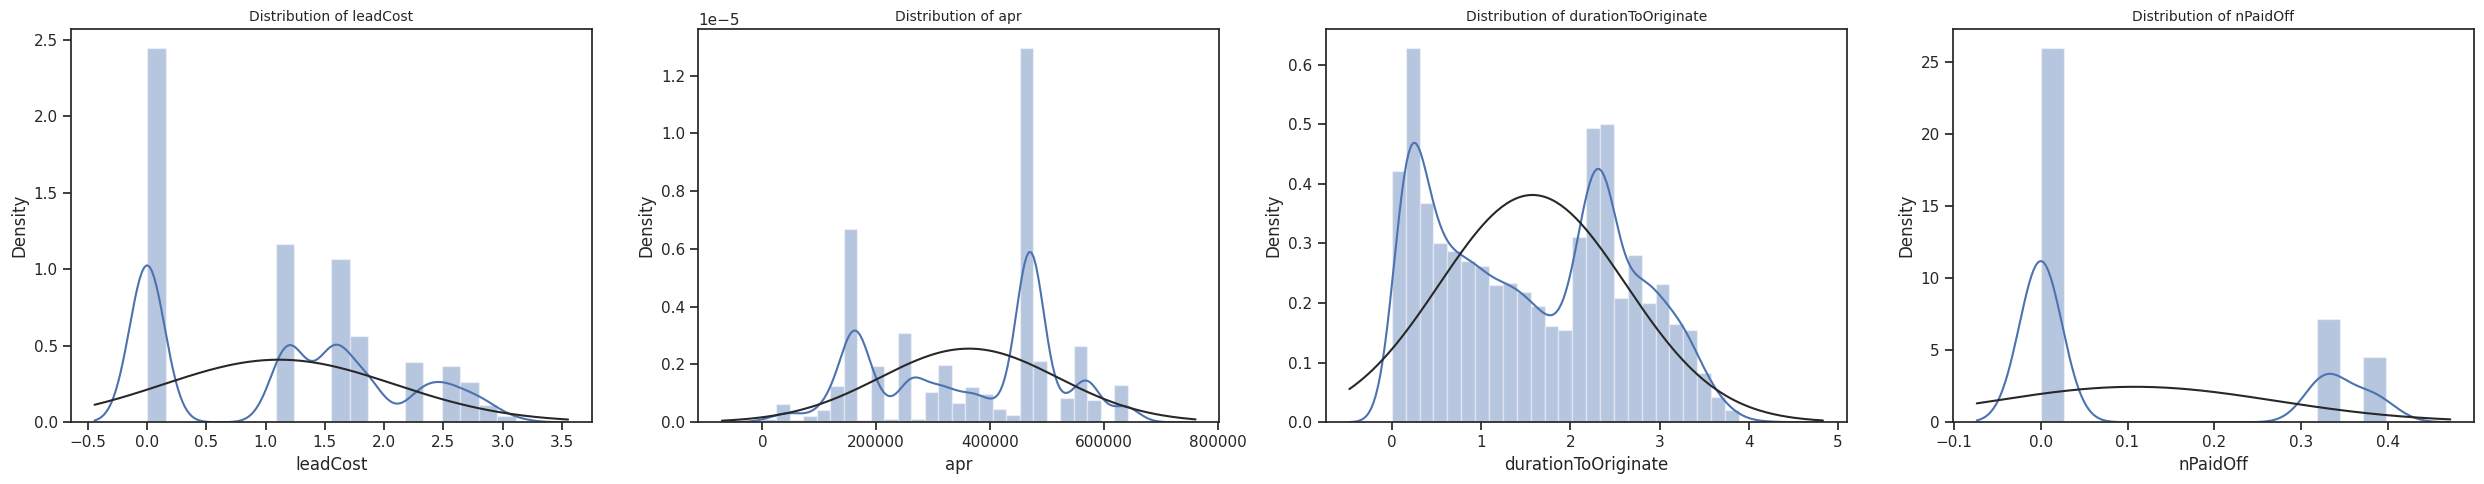

In [ ]:
#Normalized Distribution Graph for the features
plot_distributions(merged_df, selected_columns)

### Encoding Categorical Data

In [ ]:
def label_encode_columns(df, column_list):
    label_encoder = LabelEncoder()

    for column in column_list:
        # Check if the column exists in the DataFrame
        if column in df.columns:
            df[column] = label_encoder.fit_transform(df[column])
    return df

def one_hot_encode_columns(df, column_list):
    one_hot_encoder = OneHotEncoder(drop='first', sparse=False)

    for column in column_list:
        # Check if the column exists in the DataFrame
        if column in df.columns:
            # Perform one-hot encoding and append new columns to DataFrame
            one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df[[column]]),
                                           columns=[f"{column}_{category}" for category in one_hot_encoder.get_feature_names_out([column])])
            df = pd.concat([df, one_hot_encoded], axis=1)
            df.drop(columns=[column], inplace=True)
    return df

label_encode_column = ["payFrequency"]
one_hot_columns = ["leadType",  "fpStatus"]
merged_df = label_encode_columns(merged_df, label_encode_column)
merged_df = one_hot_encode_columns(merged_df, one_hot_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The payFrequency is an ordinal variable, while the other selected categorical columns are nominal variables. Thus, the Label encoder will be applied to payFrequency and the One-Hot encoder applied to fpStatus and leadType.

In [ ]:
merged_df.head(10)

loanId                          anon_ssn  payFrequency  \
0  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c             0   
1  LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c             3   
2  LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc             0   
3  LL-I-09279047  1d249e27292d25e4d3b4bc142a2a4aea             4   
4  LL-I-01316580  2a10b2e04c5eec9a47a8cf5b9b81a2b8             4   
5  LL-I-04577739  edac6e371cda7512214ba74698247a19             0   
6  LL-I-07240030  7a2dabf0d9fe553dd4136b17e3dca40b             0   
7  LL-I-06082778  6f884e233bd17aadbda6c5bd2af2260c             0   
8  LL-I-08124999  593b6d3e35436bfab3e8e6312599f5d8             3   
9  LL-I-05805964  6649208bb9d31f34bcf071cc531132c1             0   

             apr         applicationDate          originatedDate  nPaidOff  \
0   44766.097068 2016-01-19 22:07:36.778 2016-01-20 15:49:18.846  0.000000   
1  313533.467188 2017-01-31 17:48:17.381 2017-01-31 18:00:14.520  0.373309   
2  468553.313868 2016-08-27 09:08:05.442 2016-08-29 15:05:04.014  0.000000   
3  206670.387207 2016-05-25 03:05:18.849 2016-05-25 15:11:36.260  0.386332   
4  468553.313868 2015-05-26 17:02:27.312 2015-05-26 18:45:48.024  0.000000   
5  487659.162511 2015-11-12 21:07:03.953 2015-11-12 21:57:28.345  0.000000   
6  468553.313868 2016-02-14 18:17:40.530 2016-02-17 18:41:15.519  0.000000   
7  530776.015456 2015-12-26 16:30:14.247 2015-12-27 15:48:34.522  0.328587   
8  160989.388615 2016-03-25 20:08:27.702 2016-03-25 20:57:33.780  0.386332   
9  160989.388615 2015-12-16 18:43:31.248 2015-12-16 19:49:50.228  0.000000   

      loanStatus  loanAmount  originallyScheduledPaymentAmount state  \
0  Paid Off Loan    0.632221                          0.502099    CA   
1  Paid Off Loan    0.250709                          0.252827    MO   
2  Paid Off Loan    0.152605                          0.181502    CA   
3  Paid Off Loan    0.043601                          0.018948    WI   
4  Paid Off Loan    0.043601                          0.057311    MO   
5  Paid Off Loan    0.109004                          0.115501    SC   
6  Paid Off Loan    0.087203                          0.095484    OH   
7  Paid Off Loan    0.087203                          0.114264    IN   
8  Paid Off Loan    0.087203                          0.076105    IL   
9  Paid Off Loan    0.043601                          0.036150    IL   

   leadCost  clearfraudscore  durationToOriginate  isGoodLoan  \
0  0.000000         1.460809             2.268307         1.0   
1  0.000000         1.081428             0.178680         1.0   
2  1.857130        -0.737873             2.841789         1.0   
3  0.000000         0.520980             2.053230         1.0   
4  1.578585        -0.142936             0.915310         1.0   
5  1.857130         0.934850             0.577109         1.0   
6  1.192430        -1.056898             2.977464         1.0   
7  0.000000         0.917605             2.418468         1.0   
8  0.000000        -0.591294             0.566458         1.0   
9  0.000000         1.529787             0.696081         1.0   

   leadType_leadType_california  leadType_leadType_express  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   
5                           0.0                        0.0   
6                           0.0                        0.0   
7                           0.0                        0.0   
8                           0.0                        0.0   
9                           0.0                        0.0   

   leadType_leadType_instant-offer  leadType_leadType_lead  \
0                              0.0                     0.0   
1                              0.0                     0.0   
2                       

<ipython-input-18-b216238b34f4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = df.loc[:, column_name].corr()


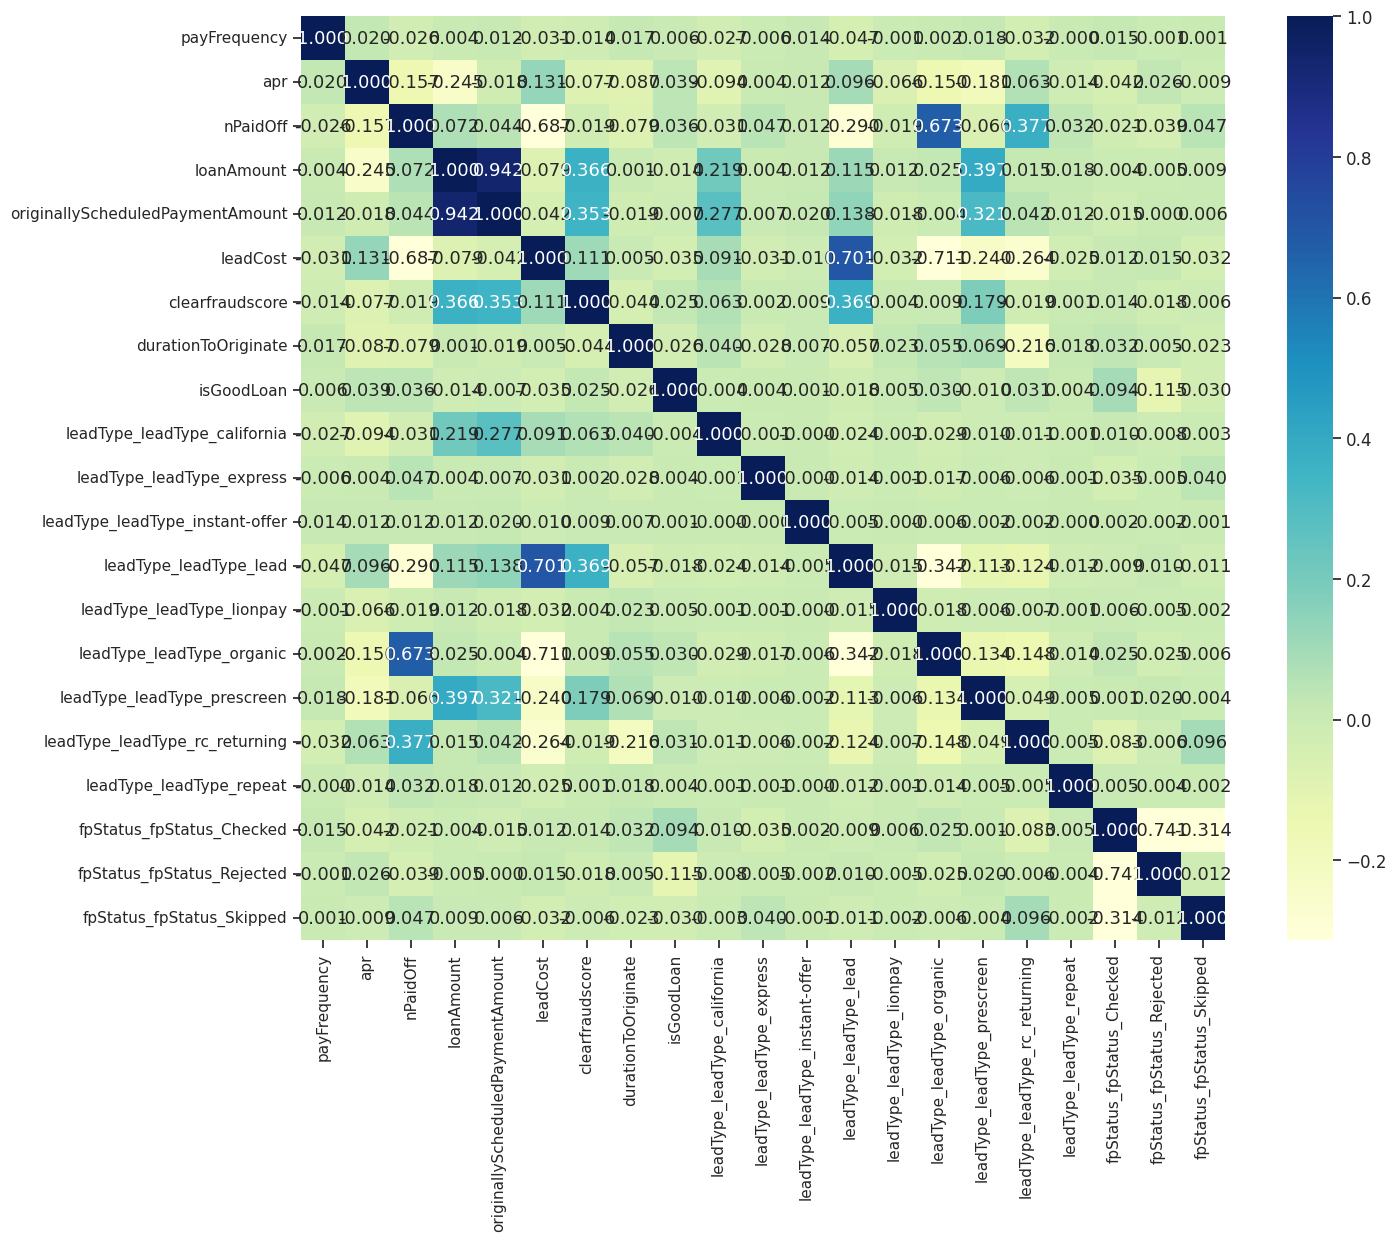

In [ ]:
col_to_remove = ["loanId", "anon_ssn", "state","applicationDate", "originatedDate"]
selected_cols = [col for col in merged_df.columns.tolist() if col not in col_to_remove]
plot_cor_matrix(merged_df, selected_cols)

We plot again the correlation matrix and we notice that there is no feature correlated with the target(isGoodLoan).

### Imbalance Data

From EDA above, we know that the target variable is imbalance. The issue can be handle by oversampling or SMOTE (Synthetic Minority Over-sampling Technique). We decide to use oversampling in current stage.

In [ ]:
def print_class_distribution(y_values, title):
    counts = pd.Series(y_values).value_counts()
    percentages = counts / len(y_values) * 100
    print(f"\n{title} Class Distribution:")
    for cls, count, percentage in zip(counts.index, counts.values, percentages.values):
        print(f"Class {cls}: Count={count}, Percentage={percentage:.2f}%")

X, y = merged_df.drop(["loanId", "anon_ssn", "applicationDate", "originatedDate", "loanStatus", "state", "isGoodLoan"], axis=1), merged_df['isGoodLoan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Class distribution before oversampling:")
print_class_distribution(y_train, "Before Oversampling")

oversampler = RandomOverSampler(random_state=0)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

#smote = SMOTE(sampling_strategy='auto')
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution after oversampling:")
print_class_distribution(y_resampled, "After Oversampling")

Class distribution before oversampling:

Before Oversampling Class Distribution:
Class 1.0: Count=9699, Percentage=97.30%
Class 0.0: Count=269, Percentage=2.70%

Class distribution after oversampling:

After Oversampling Class Distribution:
Class 1.0: Count=9699, Percentage=50.00%
Class 0.0: Count=9699, Percentage=50.00%


After we solved the imbalance, its time to move into Modeling stage

## Modeling

#### Train test split

First, we split the data into training set and testing set before fit into model.

In [ ]:
def print_class_distribution(y_values, title):
    counts = pd.Series(y_values).value_counts()
    percentages = counts / len(y_values) * 100
    print(f"\n{title} Class Distribution:")
    for cls, count, percentage in zip(counts.index, counts.values, percentages.values):
        print(f"Class {cls}: Count={count}, Percentage={percentage:.2f}%")

X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print_class_distribution(y_resampled_train, "Resampled Training Set")
print_class_distribution(y_resampled_test, "Resampled Testing Set")


Resampled Training Set Class Distribution:
Class 0.0: Count=7778, Percentage=50.12%
Class 1.0: Count=7740, Percentage=49.88%

Resampled Testing Set Class Distribution:
Class 1.0: Count=1959, Percentage=50.49%
Class 0.0: Count=1921, Percentage=49.51%


#### Model Training

Models that we will use are:

*   Support Vector Machine (SVC)
*   Naive Bayes (GNB)
*   Logistic Regression
*   RandomForestClassifier
*   K-nearest neighbors

The training data will be used to train for each model and evaluate each model's performance by using testing data.


#####  Function

In [ ]:
acscore = []
acprecision = []
acrecall = []
acF1 = []
acTrainingTime = []

def model_training(classifier, x_train, x_test, y_train, y_test):
    start = time.time()
    classifier.fit(x_train, y_train)
    stop = time.time()
    trainingTime = stop - start
    print(f"Training time: {trainingTime}s")

    # Predicting the test set
    y_pred = classifier.predict(x_test)

    # Making the confusion matrix and calculating accuracy score
    cm = confusion_matrix(y_test, y_pred)
    ac = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    acscore.append(ac)
    acprecision.append(precision)
    acrecall.append(recall)
    acF1.append(f1)
    acTrainingTime.append(trainingTime)

    sns.heatmap(cm, xticklabels=['Bad_Loan', 'Good_Loan'], yticklabels=['Actual_Bad_Loan', 'Actual_Good_Loan'],
                annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    print('Accuracy score: {0:0.3f}'.format(ac))
    print('Precision score: {0:0.3f}'.format(precision))
    print('Recall score: {0:0.3f}'.format(recall))
    print('F1 score: {0:0.3f}'.format(f1))
    print('Training Accuracy: ',classifier.score(x_train, y_train))
    print('Testing Accuracy: ',classifier.score(x_test, y_test))
    target_names = ['Bad_Loan', 'Good_Loan']
    print(classification_report(y_test, y_pred, target_names=target_names))

def model_roc_curve(classifier, x_train, x_test, y_train, y_test):
    classifier.fit(x_train, y_train)
    predProb = classifier.predict_proba(x_test)
    preds = predProb[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt_roc_curve(fpr, tpr, roc_auc)

def plt_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

##### SVC

Training time: 87.6054413318634s
Accuracy score: 0.568
Precision score: 0.555
Recall score: 0.729
F1 score: 0.630
Training Accuracy:  0.5681144477381106
Testing Accuracy:  0.5682989690721649
              precision    recall  f1-score   support

    Bad_Loan       0.59      0.40      0.48      1921
   Good_Loan       0.56      0.73      0.63      1959

    accuracy                           0.57      3880
   macro avg       0.57      0.57      0.56      3880
weighted avg       0.57      0.57      0.56      3880



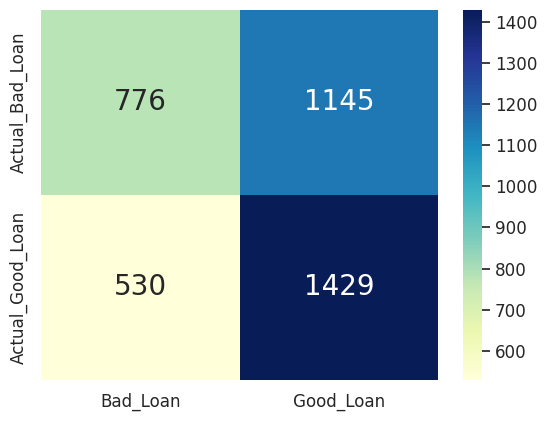

In [ ]:
svc = SVC(probability=True, random_state = 42)
model_training(svc, X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test)

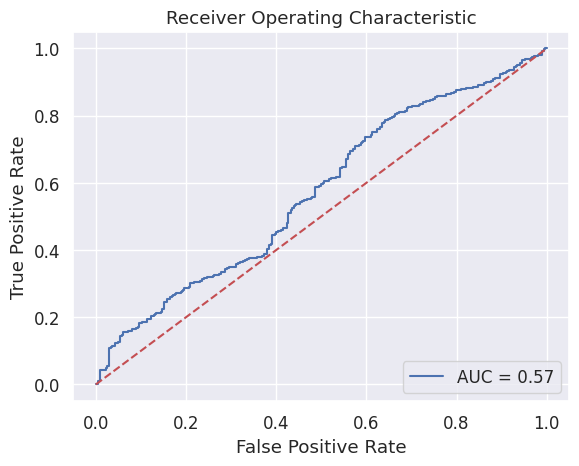

In [ ]:
model_roc_curve(svc, X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test)

##### GNB

Training time: 0.018494844436645508s
Accuracy score: 0.547
Precision score: 0.548
Recall score: 0.590
F1 score: 0.568
Training Accuracy:  0.5436911973192422
Testing Accuracy:  0.5474226804123712
              precision    recall  f1-score   support

    Bad_Loan       0.55      0.50      0.52      1921
   Good_Loan       0.55      0.59      0.57      1959

    accuracy                           0.55      3880
   macro avg       0.55      0.55      0.55      3880
weighted avg       0.55      0.55      0.55      3880



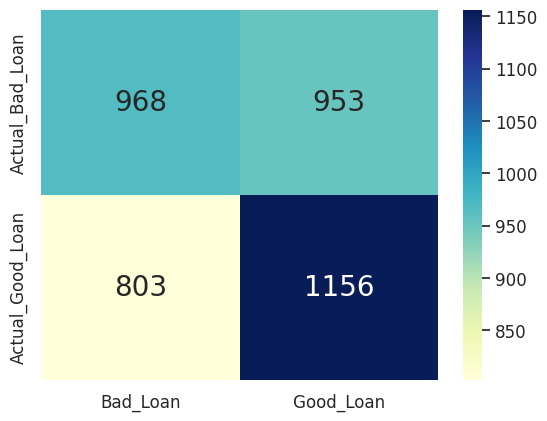

In [ ]:
GNBclassifier = GaussianNB()
model_training(GNBclassifier, X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test)

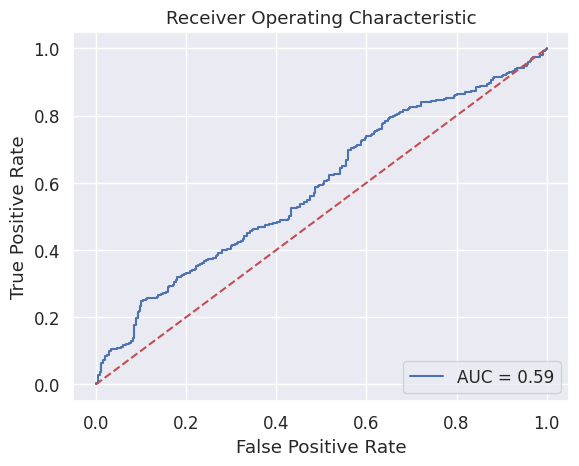

In [ ]:
model_roc_curve(GNBclassifier, X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test)

##### Logistic Regression

Training time: 0.04709053039550781s
Accuracy score: 0.505
Precision score: 0.505
Recall score: 1.000
F1 score: 0.671
Training Accuracy:  0.49871117412037635
Testing Accuracy:  0.5048969072164948
              precision    recall  f1-score   support

    Bad_Loan       0.00      0.00      0.00      1921
   Good_Loan       0.50      1.00      0.67      1959

    accuracy                           0.50      3880
   macro avg       0.25      0.50      0.34      3880
weighted avg       0.25      0.50      0.34      3880



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


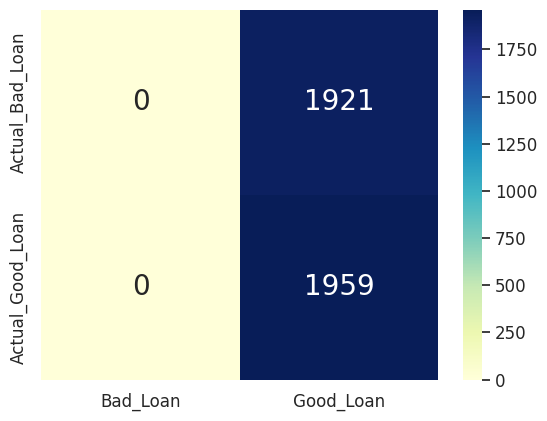

In [ ]:
Logistic = LogisticRegression(random_state=42)
model_training(Logistic, X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test)

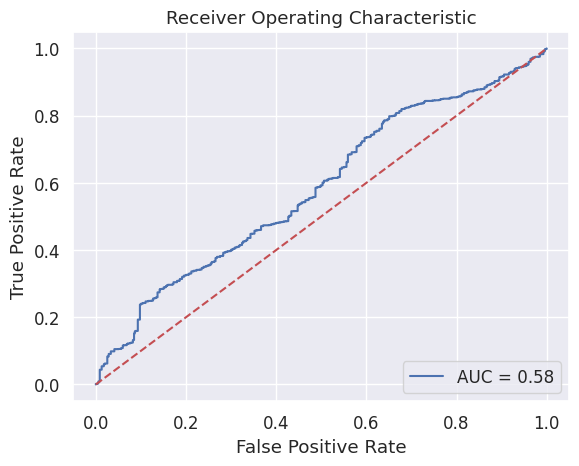

In [ ]:
model_roc_curve(Logistic, X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test)

##### Random Forest

Training time: 0.956228494644165s
Accuracy score: 0.693
Precision score: 0.676
Recall score: 0.752
F1 score: 0.712
Training Accuracy:  0.7045366670962753
Testing Accuracy:  0.6927835051546392
              precision    recall  f1-score   support

    Bad_Loan       0.71      0.63      0.67      1921
   Good_Loan       0.68      0.75      0.71      1959

    accuracy                           0.69      3880
   macro avg       0.70      0.69      0.69      3880
weighted avg       0.69      0.69      0.69      3880



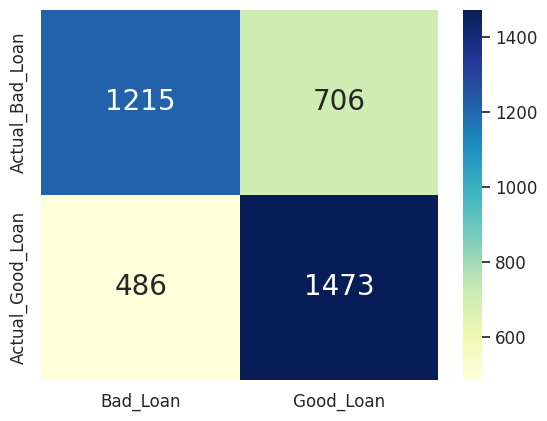

In [ ]:
RFC = RandomForestClassifier(n_estimators=100, max_depth=5)

model_training(RFC, X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test)

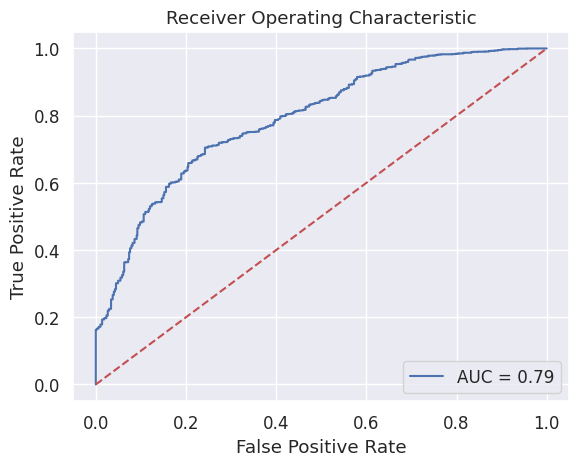

In [ ]:
model_roc_curve(RFC, X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test)

##### KNN

Training time: 0.0062541961669921875s
Accuracy score: 0.977
Precision score: 0.977
Recall score: 1.000
F1 score: 0.988
Training Accuracy:  0.973314606741573
Testing Accuracy:  0.9767348576012836
              precision    recall  f1-score   support

    Bad_Loan       0.00      0.00      0.00        57
   Good_Loan       0.98      1.00      0.99      2436

    accuracy                           0.98      2493
   macro avg       0.49      0.50      0.49      2493
weighted avg       0.95      0.98      0.97      2493



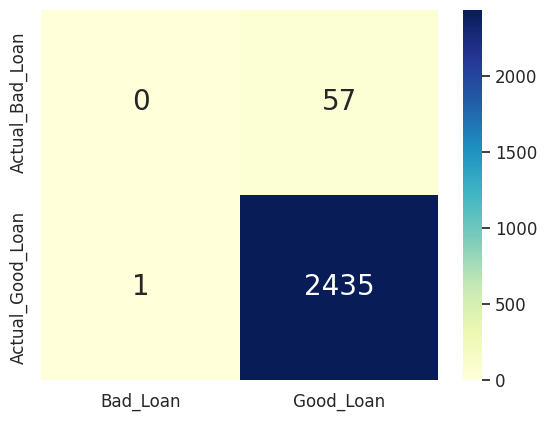

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=5)

model_training(KNN, X_train, X_test, y_train, y_test)

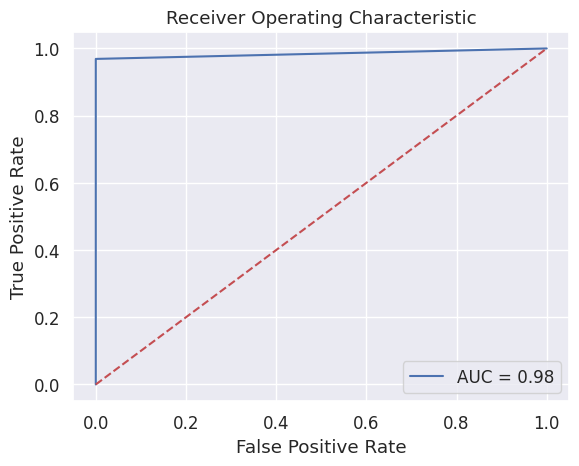

In [ ]:
model_roc_curve(KNN, X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test)

Based on the graphs above, the KNN having the best performance of ROC-AUC score of 0.98. The RF is ranked second with ROC-AUC score of 0.80. The other models (SVC, GNB and LR) performance are not ideal since their ROC-AUC score are below than 0.60.

## Model Evaluation

##### Evaluation Metrics

In [ ]:
def plot_evaluation_metrics(models, y, title):
    plt.rcParams['figure.figsize']=15,8
    sns.set_style("darkgrid")
    ax = sns.barplot(x=models, y=y, palette = "rocket", saturation =1.5)
    plt.xlabel("Classifier Models", fontsize = 20 )
    plt.ylabel("% of Accuracy", fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.xticks(fontsize = 13, horizontalalignment = 'center', rotation = 0)
    plt.yticks(fontsize = 13)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        xPlot, yPlot = p.get_xy()
        ax.annotate(f'{height:.3%}', (xPlot + width/2, yPlot + height*1.02), ha='center', fontsize = 'x-large')
    plt.show()

<ipython-input-54-457c319a3898>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=y, palette = "rocket", saturation =1.5)


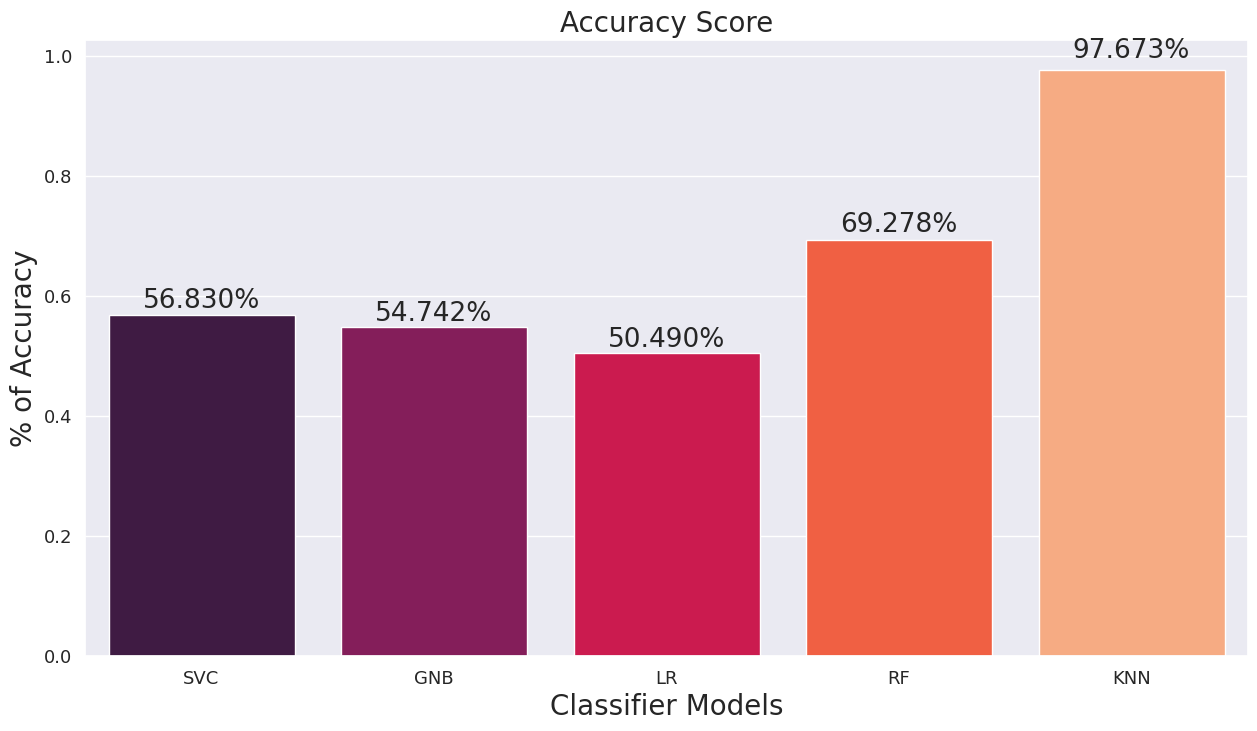

In [ ]:
models = ["SVC", "GNB", "LR", "RF", "KNN"]
# Visualising the accuracy score of each classification model
plot_evaluation_metrics(models, acscore, "Accuracy Score")

The KNN has the highest accuracy score which is 97.673%. The performance of RF is also quite well which 69.278%. While the other 3 models do not have a good performance.

<ipython-input-54-457c319a3898>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=y, palette = "rocket", saturation =1.5)


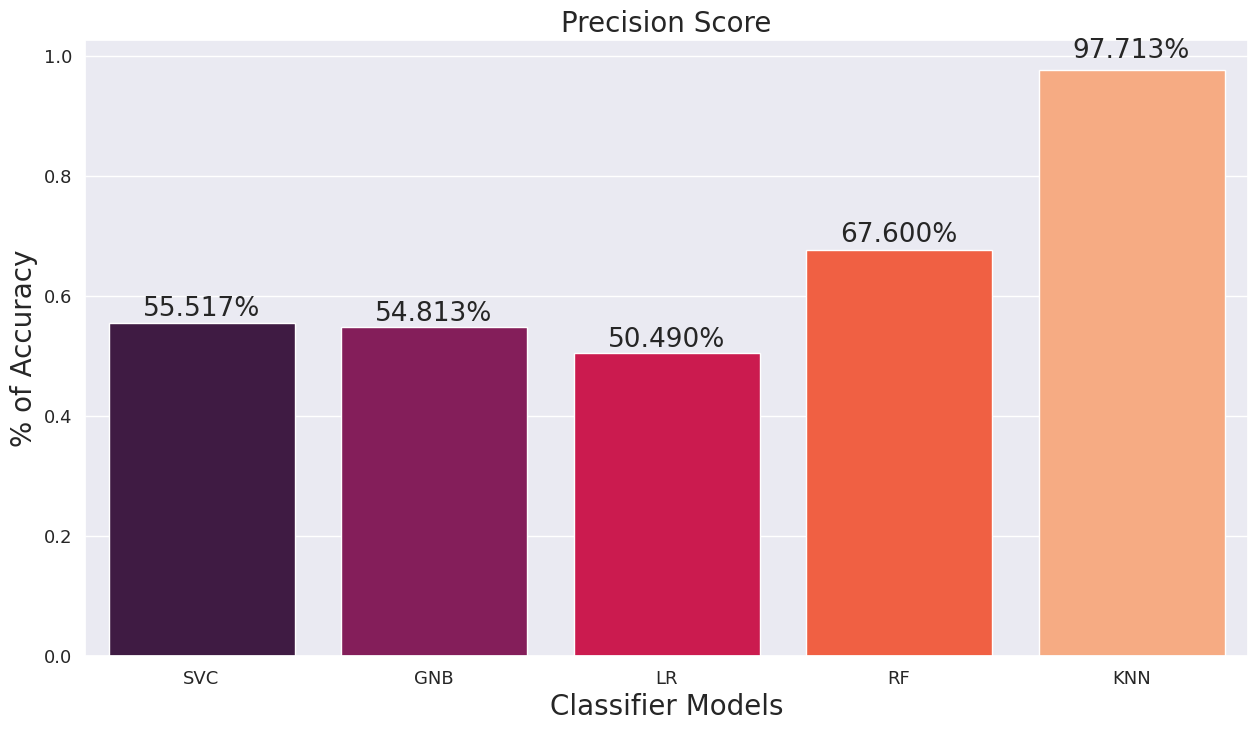

In [ ]:
plot_evaluation_metrics(models, acprecision, "Precision Score")

For the precision score, the KNN still has the highest score 97.713% followed by RF which is 67.600%. While the other 3 models still not have the ideal performance.

<ipython-input-54-457c319a3898>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=y, palette = "rocket", saturation =1.5)


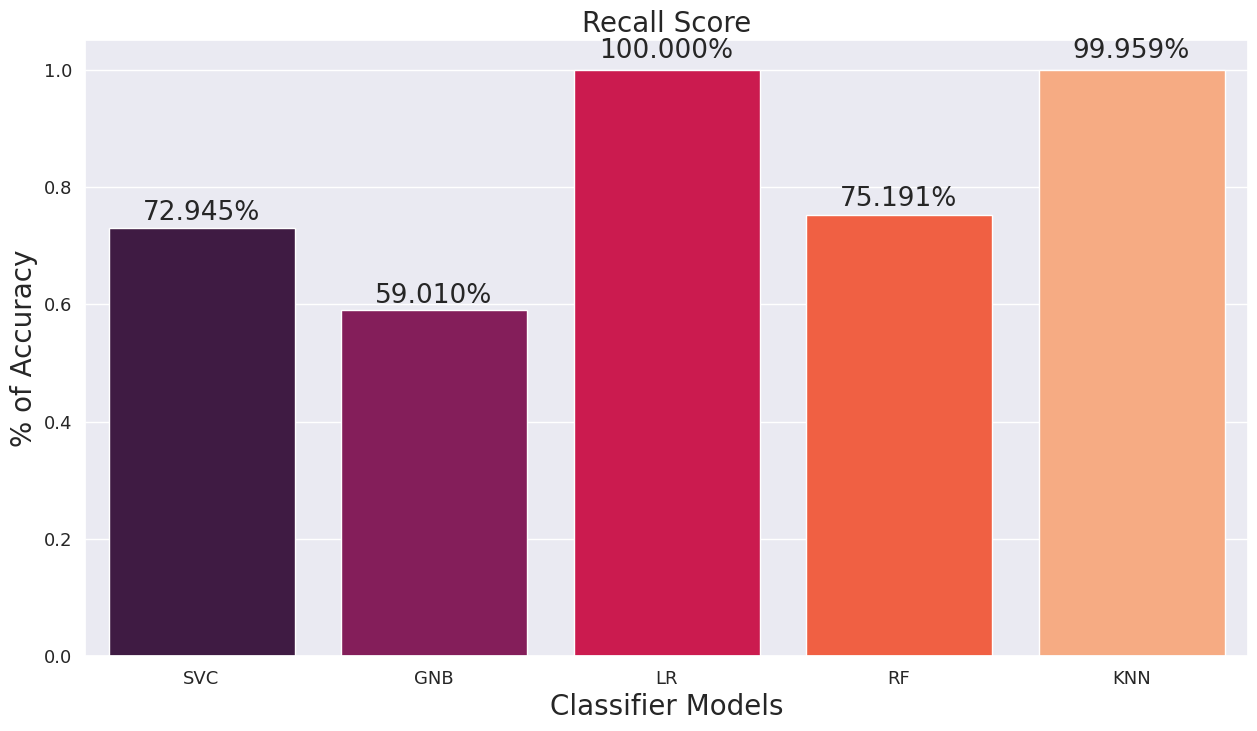

In [ ]:
plot_evaluation_metrics(models, acrecall, "Recall Score")

For Recall score, it is surprise that LR model having the 100%. The KNN still perform overwhelmingly good which 99.959%. The SVC also had 72.945% however the GNB still remaining the low performance.

<ipython-input-54-457c319a3898>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=y, palette = "rocket", saturation =1.5)


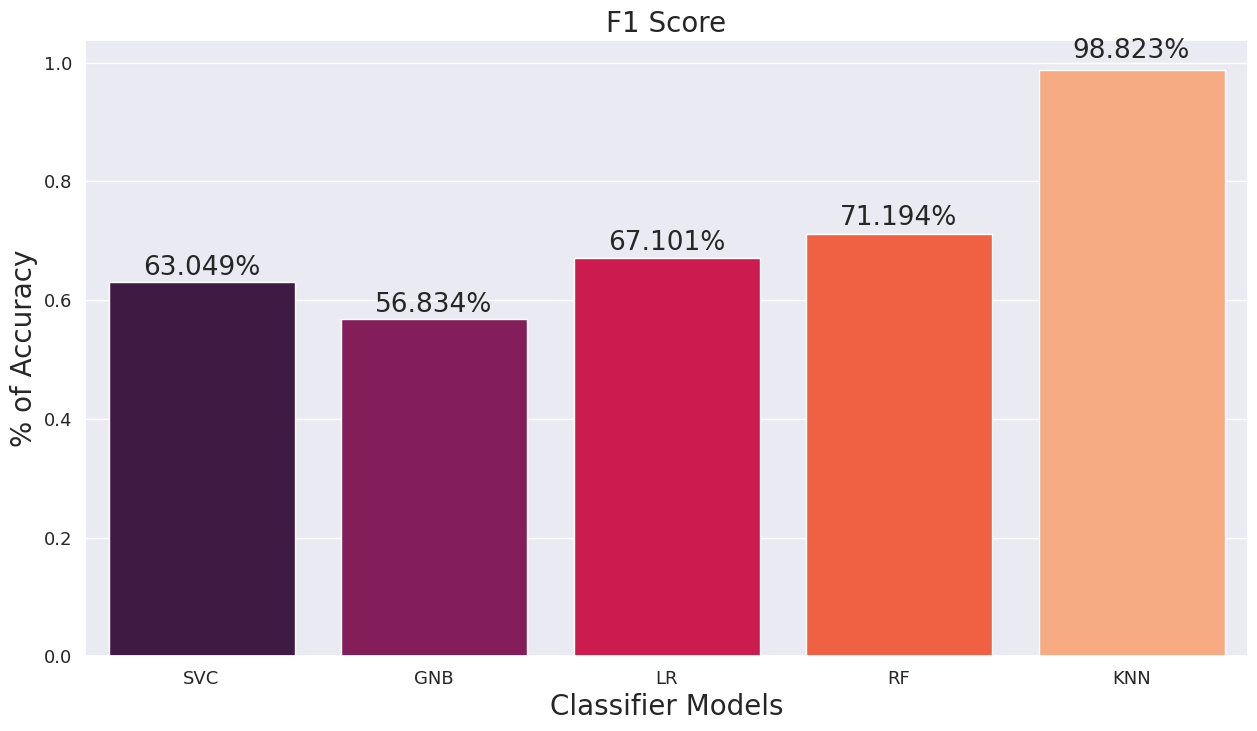

In [ ]:
plot_evaluation_metrics(models, acF1, "F1 Score")

While looking at F1 score, KNN still ranked first which 98.823%, then followed by RF which 71.194%. The GNB is having the lowest performance compared to others.

<ipython-input-59-0c901b68e33a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=acTrainingTime, palette = "rocket", saturation =1.5)


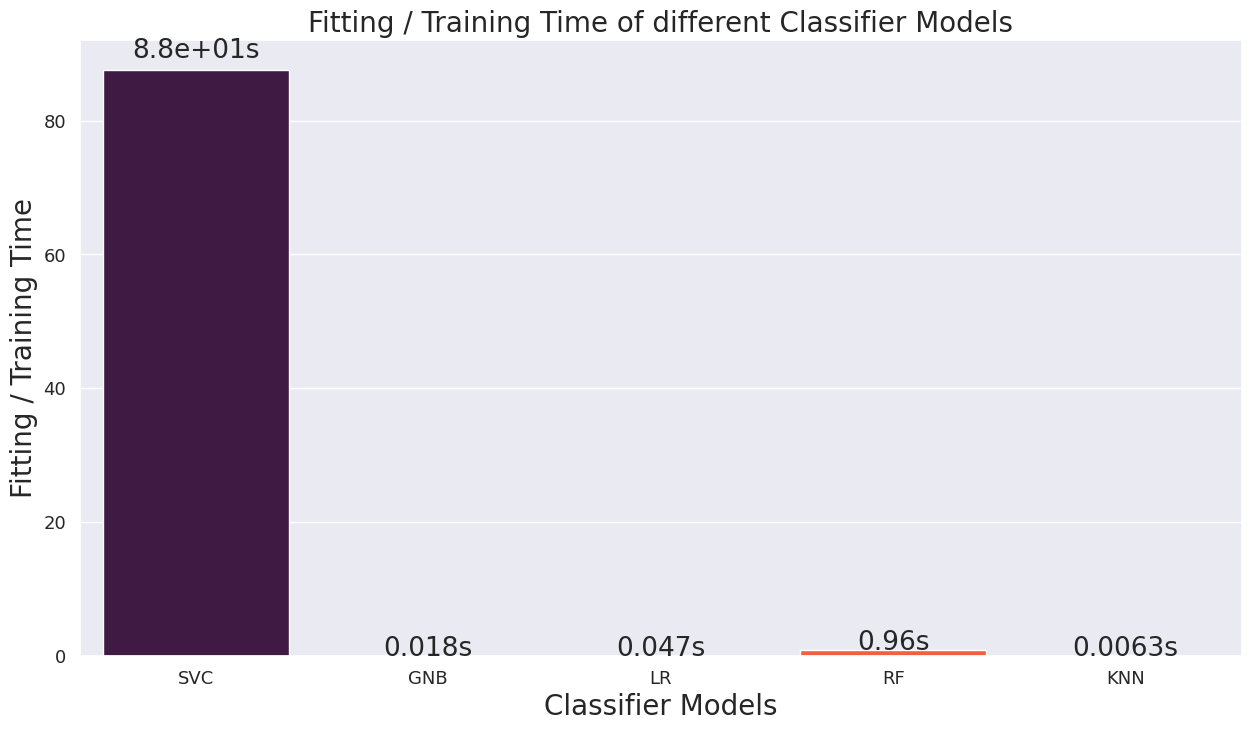

In [ ]:
def plot_training_duration(models, acTrainingTime):
  plt.rcParams['figure.figsize']=15,8
  sns.set_style("darkgrid")
  ax = sns.barplot(x=models, y=acTrainingTime, palette = "rocket", saturation =1.5)
  plt.xlabel("Classifier Models", fontsize = 20 )
  plt.ylabel("Fitting / Training Time", fontsize = 20)
  plt.title("Fitting / Training Time of different Classifier Models", fontsize = 20)
  plt.xticks(fontsize = 13, horizontalalignment = 'center', rotation = 0)
  plt.yticks(fontsize = 13)
  for p in ax.patches:
      width, height = p.get_width(), p.get_height()
      xPlot, yPlot = p.get_xy()
      ax.annotate(f'{height:.2}''s', (xPlot + width/2, yPlot + height*1.02), ha='center', fontsize = 'x-large')
  plt.show()
plot_training_duration(models, acTrainingTime)

Based on the graph above, we notice that SVC uses much training duration compared to other models. It is not appropriate to use this model since it consumes much computation resources and its performance not considered high.

##### Cross Validation

The cross validation will be perform to all models except SVC since it use much of resources.

In [ ]:
CVMean = []
CVSD = []
models.remove("SVC")
tupleModel = [GNBclassifier, Logistic, RFC, KNN]
a = 0
for selected_model in tupleModel:
    result = cross_val_score(selected_model ,X_resampled, y_resampled, cv=5, scoring='accuracy')
    print(selected_model,":", result)
    CVMean.append(result.mean())
    CVSD.append(result.std())


GaussianNB() : [0.55103093 0.54819588 0.54097938 0.54111885 0.54369683]
LogisticRegression(random_state=42) : [0.5       0.5       0.5       0.5001289 0.4996133]
RandomForestClassifier(max_depth=5) : [0.71159794 0.71494845 0.70927835 0.71539056 0.72003094]
KNeighborsClassifier() : [0.96546392 0.95438144 0.95721649 0.95720547 0.9523073 ]


<ipython-input-54-457c319a3898>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=y, palette = "rocket", saturation =1.5)


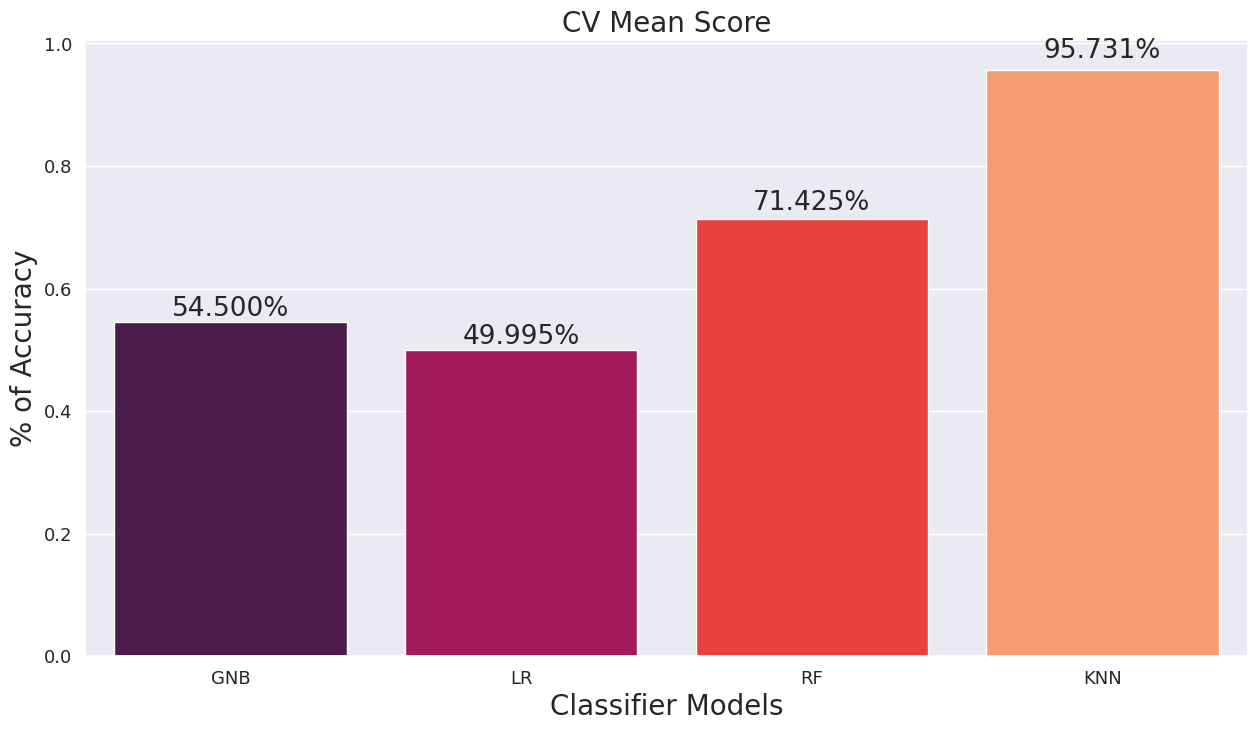

In [ ]:
plot_evaluation_metrics(models, CVMean, "CV Mean Score")

<ipython-input-54-457c319a3898>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=y, palette = "rocket", saturation =1.5)


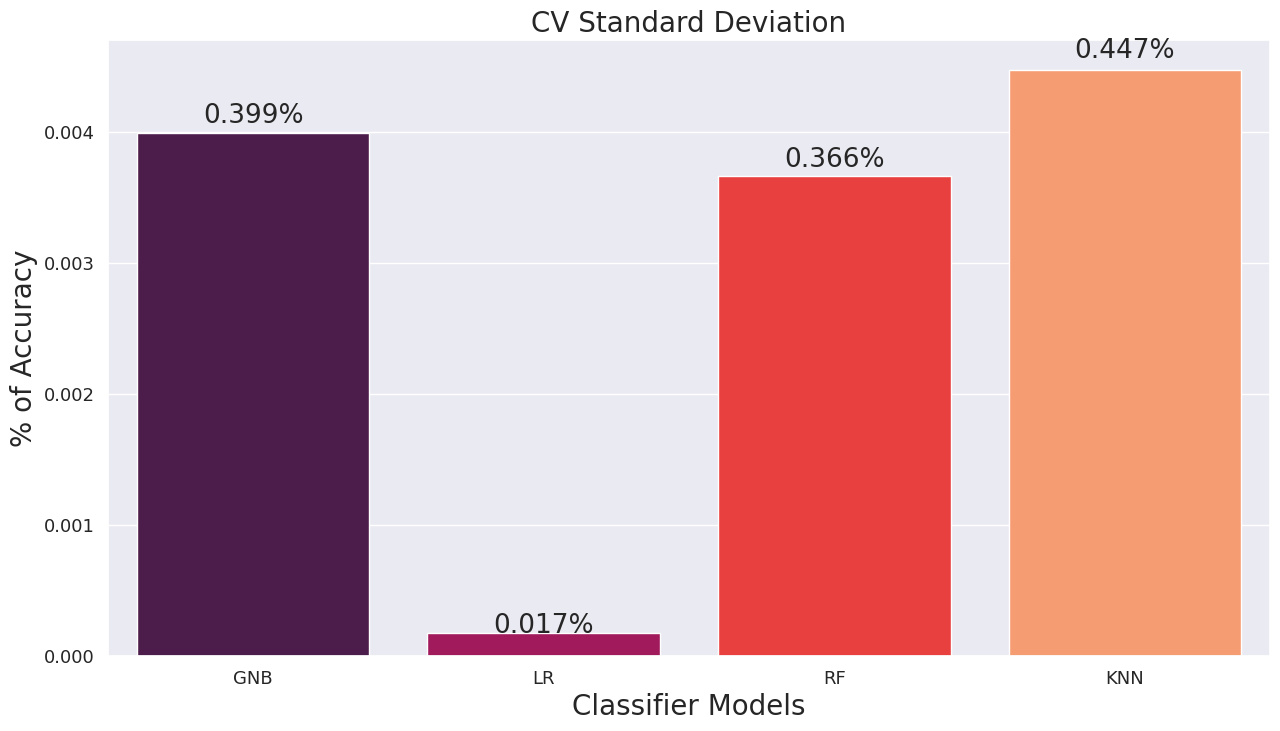

In [ ]:
plot_evaluation_metrics(models,CVSD,"CV Standard Deviation")

From cross validation result, The KNN outperforms the other models with highest cross validation mean score and accuracy score. It also has low cross validation standard deviation and ROC-AUC score of 0.98. Therefore, KNN is the most suitable  model for this project.

##### Feature Importance

K-Nearest Neighbors (KNN) does not provide a direct measure of feature importance like some other algorithms, hence understanding feature importance in a KNN model might be more difficult. However, one method to acquire insight into feature relevance is to look at how individual features affect distances between points.

We decided not to spend time and computation resources on this since it is difficult compared to other models and we had to get some valuable insight from the features in the EDA stage. But keep in mind, we should do it in real-world cases.

## Conslusion

In this notebook, we went through a good portion of the data science pipeline. Which are business understanding, data understanding, data preparation, modeling, and model evaluation.

There are different classification models being used in this project such as Support Vector Machine(SVM), Gaussian Naive Bayes (GaussianNB), Linear Regression (LR), Random Forest(RF), and K-nearest neighbors algorithm(KNN).

The KNN will be the ideal model to apply in this loan prediction (binary classification) project compared to other models. The performance of KNN is outstanding because it has the ROC-AUC score of 98%, decent evaluation metrics scoring, high cross-validation mean score, and low cross-validation standard deviation.

### Problem and limitations

Although this project is able to classify loan quality with high accuracy based on the given feature data. There are some limitations and problems in this project. The major concern of this project is the size of the dataset. The dataset is not considered large and it is imbalanced. The total rows of the dataset are 9968 rows and there are only 269 (2.70%) rows of data that can labeled as bad loans before resampling.

### Futher Work

Here are some of the future work that can be done to enhance the model's performance.


1. Although the performance of the selected model in this project is outstanding, the model fine-tuning step still should be done to ensure the model is trained well and also optimized for real-world deployment. Therefore model fine-tuning should not be skipped in the real-world. The fine-tuning stage was skipped in this project because of the decent performance of the KNN model (ROC-AUC score of 98%) and the limitation of time.

2. Importing or getting extra features to the dataset would be considered to improve the model's performance. The relevant data like income, credit scores like CTOS, number of dependencies, the purpose of the loan, and debt (liability) would be useful to enhance the predictive performance of the model. Do note that more features are not always better. Too many features will increase the risk of overfitting. Therefore, dimensionality reduction techniques like Principal Component Analysis (PCA) or feature selection need to be applied to avoid the occurrences of overfitting.

3. Futhermore, we can try ro remove the target and perform the clustering or known as unsupervied learning to enrich the classification model or to perform a form of cross-validation. Using clustering in conjunction with classification can offer valuable insights and potentially improve model performance.

4. Finally, Trying additional models like XGBoost and Neural Network would be a good approach since there may be more suitable models to be implemented within the project. Besides, using different data preprocessing methods may lead to different results for the model. We should repeatedly progress with different approaches until we find the optimal solution. Keep in mind that we will never know the result if we never tried it.